# Сборный проект - определяющие успешность игры закономерности

Аналитика интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Имеются данные до 2016 года, необходимые для планирования кампании на 2017-й. 

In [88]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as st

## Загрузка данных

In [89]:
try:
    games_df = pd.read_csv('games.csv')
except:
    games_df = pd.read_csv('https://*****/games.csv')

Отобразим первые строки датафрейма и информацию о нём

In [90]:
games_df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [91]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод** Успешно загружен датафрейм, который содержит 16715 строк

## Предобработка данных

### Приведём названия столбцов к нижнему регистру

In [92]:
games_df.rename(columns=str.lower, inplace=True)

In [93]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Приведём типы данных

Нужно столбец `year_of_release` привести к типу `int`. Предварительно заменим все пустые значения на заполняющее значение 1900. Мы будем знать, что если у игры написано, что она вышла в 1900 году, то мы не имеем информации о её дате релиза.

In [94]:
#Процент пустых значений year_of_release
games_df['year_of_release'].isna().mean() * 100

1.609332934489979

In [95]:
games_df['year_of_release'] = games_df['year_of_release'].fillna(1900)

In [96]:
games_df['year_of_release'] = games_df['year_of_release'].astype('int', errors='ignore')

Приведём столбец `user_score` к типу `float64`.

In [97]:
games_df['user_score'].describe()

count     10014
unique       96
top         tbd
freq       2424
Name: user_score, dtype: object

Видим, что помимо числовых значений есть текстовое значение 'tbd'. TBD означает "to be decided", т.е. "подлежит уточнению". Такая оценка обычно ставится, когда собранных данных слишком мало, чтобы дать честное усреднённое значение. Заменим это значение на NaN

In [98]:
games_df.loc[games_df['user_score'] == 'tbd','user_score'] = np.nan

In [99]:
games_df['user_score'].describe()

count     7590
unique      95
top        7.8
freq       324
Name: user_score, dtype: object

In [100]:
games_df['user_score'] = games_df['user_score'].astype('float', errors='ignore')

Проверим приведение типов столбцов `year_of_release` и `user_score`

In [101]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int32  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.3+ MB


### Заполнение пропусков

Найдём количество и процентное значение пропусков

In [102]:
isna = pd.concat([games_df.isna().sum(), round(games_df.isna().mean()*100, 2)], axis=1)
isna.columns = ['count', 'percent']
isna

,count,percent
name,2,0.01
platform,0,0.00
year_of_release,0,0.00
genre,2,0.01
na_sales,0,0.00
eu_sales,0,0.00
jp_sales,0,0.00
other_sales,0,0.00
critic_score,8578,51.32
user_score,9125,54.59


In [103]:
games_df[games_df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В столбцах  `critic_score`, `user_score`, `rating` пропусков около половины, но в столбцах `name` и `genre` так же присутствуют 2 пропуска. Удалим строки с пустыми значениями `name` и `genre`.

In [104]:
games_df = games_df.dropna(subset=['name'])
games_df = games_df.reset_index(drop=True)

В строке `rating` хранятся данные о рейтинге игры от ESRB. Пропуски в этом столбце заменим значением 'N.A.', что означает "not available" или "недоступно", "нет данных"

In [105]:
games_df['rating'] = games_df['rating'].fillna('N.A.')

В столбцах `critic_score`, `user_score` пропуски оставим как есть

#### Пропуски в оценках критиков

,na,all,part
year_of_release,,,
1980,9,9,100.000000
1981,46,46,100.000000
1982,36,36,100.000000
1983,17,17,100.000000
1984,14,14,100.000000
1985,13,14,92.857143
1986,21,21,100.000000
1987,16,16,100.000000
1988,14,15,93.333333


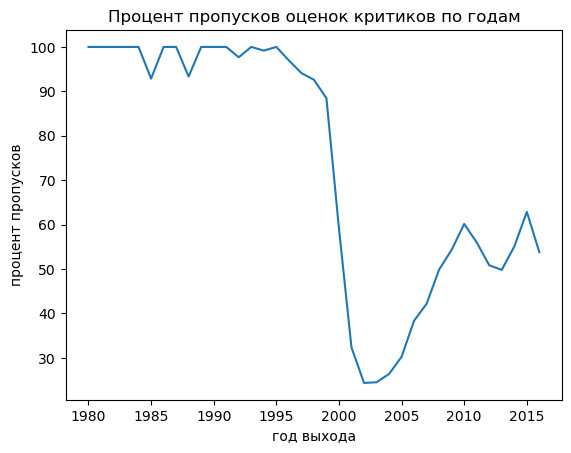

In [106]:
na_critic_pivot = (games_df[(games_df['critic_score'].isna()) & (games_df['year_of_release'] != 1900)]
 .pivot_table(index='year_of_release', values='name', aggfunc='count')
 .merge(games_df.pivot_table(index='year_of_release', values='name', aggfunc='count'),
       on='year_of_release')
)
na_critic_pivot.columns = ['na', 'all']
na_critic_pivot['part'] = na_critic_pivot['na'] / na_critic_pivot['all'] * 100
display(na_critic_pivot)
na_critic_pivot['part'].plot()
plt.title('Процент пропусков оценок критиков по годам')
plt.xlabel('год выхода')
plt.ylabel('процент пропусков')
plt.show()

До конца 90-х процент пропусков близок к 100%. Это связано с тем, что в те времена критикам просто негде было оставлять своё мнение, существовало несколько официальных журналов для конкретных платформ, Интернет еще не получил повсеместное распостранение. С конца 90-х - время расцвета печтаных журналов про игры, Интернет активно развивается. С конца 00-х печатные журналы начинают активно закрываться, а тематические сайты, видимо, не способны в полной мере обеспечить обзорами все выходящие игры

#### Пропуски в пользовательских оценках

,na,all,part
year_of_release,,,
1980,9,9,100.000000
1981,46,46,100.000000
1982,36,36,100.000000
1983,17,17,100.000000
1984,14,14,100.000000
1985,13,14,92.857143
1986,21,21,100.000000
1987,16,16,100.000000
1988,14,15,93.333333


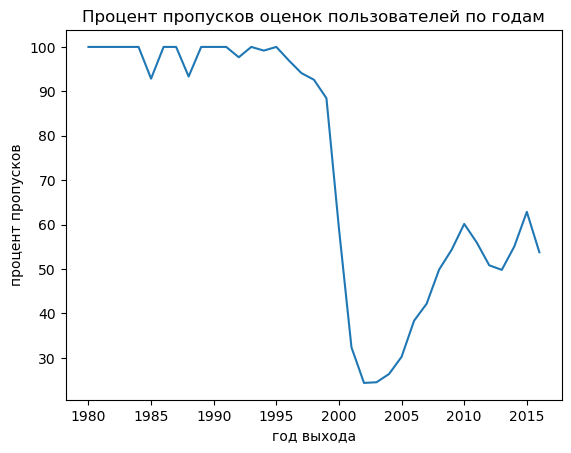

In [107]:
na_user_pivot = (games_df[(games_df['user_score'].isna()) & (games_df['year_of_release'] != 1900)]
 .pivot_table(index='year_of_release', values='name', aggfunc='count')
 .merge(games_df.pivot_table(index='year_of_release', values='name', aggfunc='count'),
       on='year_of_release')
)
na_user_pivot.columns = ['na', 'all']
na_user_pivot['part'] = na_critic_pivot['na'] / na_critic_pivot['all'] * 100
display(na_user_pivot)
na_user_pivot['part'].plot()
plt.title('Процент пропусков оценок пользователей по годам')
plt.xlabel('год выхода')
plt.ylabel('процент пропусков')
plt.show()

### Дубликаты

In [108]:
games_df.duplicated().sum()

0

Полностью совпадающих строк нет. 

Поищем тоньше. Будем считать, что игра продублирована, если название игры и платформа выпуска совпадают

In [109]:
games_df[['name','platform']].duplicated().sum()

4

Найдено 4 записи. Отобразим их и обработаем

In [110]:
games_df[games_df[['name','platform']].duplicated()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1590,Need for Speed: Most Wanted,X360,2005,Racing,1.0,0.13,0.02,0.10,83.0,8.5,T
4126,Sonic the Hedgehog,PS3,1900,Platform,0.0,0.48,0.00,0.00,43.0,4.1,E10+
11714,Need for Speed: Most Wanted,PC,2012,Racing,0.0,0.06,0.00,0.02,82.0,8.5,T
16228,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.00,0.00,83.0,5.5,E


In [111]:
games_df[(games_df['name'] == 'Need for Speed: Most Wanted') & (games_df['platform'] == 'X360')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1189,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1590,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T


In [112]:
games_df[(games_df['name'] == 'Need for Speed: Most Wanted') & (games_df['platform'] == 'PC')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5971,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.0,0.04,82.0,8.5,T
11714,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.0,0.02,82.0,8.5,T


In [113]:
games_df[(games_df['name'] == 'Sonic the Hedgehog') & (games_df['platform'] == 'PS3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1744,Sonic the Hedgehog,PS3,2006,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
4126,Sonic the Hedgehog,PS3,1900,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+


In [114]:
games_df[(games_df['name'] == 'Madden NFL 13') & (games_df['platform'] == 'PS3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16228,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Видим, что у игры 'Need For Speed: Most Wanted' отличаются годы релиза. Значит, это ремейк оригинальной игры, и дубликатами не считаются. 

Для игр 'Sonic the Hedgehog' и 'Madden NFL 13' имеем дубликаты записей. Сложим значения продаж, дубликаты удалим

In [115]:
games_df.loc[1744,'eu_sales'] = games_df.loc[1744,'eu_sales'] + games_df.loc[4126, 'eu_sales']
games_df.loc[604,'eu_sales'] = games_df.loc[604,'eu_sales'] + games_df.loc[16228, 'eu_sales']
games_df = games_df.drop([4126, 16228], axis=0)

In [116]:
games_df[games_df[['name','platform']].duplicated()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1590,Need for Speed: Most Wanted,X360,2005,Racing,1.0,0.13,0.02,0.10,83.0,8.5,T
11714,Need for Speed: Most Wanted,PC,2012,Racing,0.0,0.06,0.00,0.02,82.0,8.5,T


### Вспомогательные столбцы

Добавим столбец с сумарными продажами во всех регионах

In [117]:
games_df['total_sales'] = games_df['na_sales']+games_df['eu_sales']+games_df['jp_sales']+games_df['other_sales']

### Инфо после предобработки

Отобразим информацию о датафрейме после предобработки: первые строки, инфо и пропуски

In [118]:
games_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,N.A.,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,N.A.,31.38


In [119]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16711 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16711 non-null  object 
 1   platform         16711 non-null  object 
 2   year_of_release  16711 non-null  int32  
 3   genre            16711 non-null  object 
 4   na_sales         16711 non-null  float64
 5   eu_sales         16711 non-null  float64
 6   jp_sales         16711 non-null  float64
 7   other_sales      16711 non-null  float64
 8   critic_score     8135 non-null   float64
 9   user_score       7588 non-null   float64
 10  rating           16711 non-null  object 
 11  total_sales      16711 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.6+ MB


In [120]:
isna = pd.concat([games_df.isna().sum(), round(games_df.isna().mean()*100, 2)], axis=1)
isna.columns = ['count', 'percent']
isna

,count,percent
name,0,0.00
platform,0,0.00
year_of_release,0,0.00
genre,0,0.00
na_sales,0,0.00
eu_sales,0,0.00
jp_sales,0,0.00
other_sales,0,0.00
critic_score,8576,51.32
user_score,9123,54.59


### Выводы предобработки

Во время предобработки данных:
* названия всех столбцов датафрейма были приведены к нижнему регистру
* значения в столбцах `year_of_release` и `user_score` приведены к нужным типам данных
* обработаны скрытые дубликаты 
* обработаны пропуски в данных. В столбцах `year_of_release` и `rating` пропуски заполнены значениями 1900 и 'N.A.' соответственно. Пропуски в столбцах `name` и `genre` удалены
* добавлен столбец с сумарными продажами во всех регионах

## Исследовательский анализ данных

### Год выпуск игры

Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [121]:
games_df['year_of_release'].describe()

count    16711.000000
mean      2004.778170
std         14.591576
min       1900.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

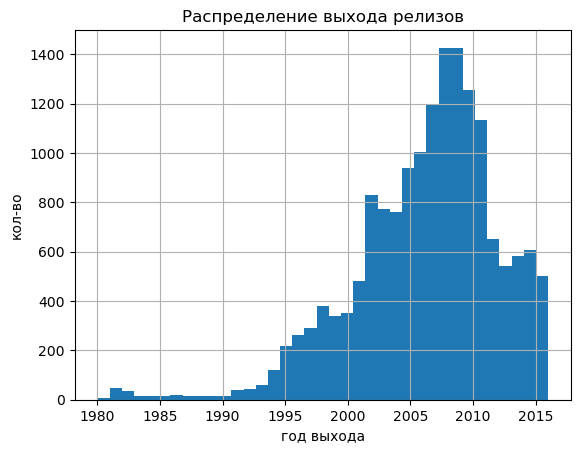

In [122]:
games_df.hist('year_of_release', range=(1980,2016), bins=37);
plt.title('Распределение выхода релизов')
plt.xlabel('год выхода')
plt.ylabel('кол-во')
plt.show()

In [123]:
print('Количество игр, вышедших до 1990:')
print(games_df[(games_df['year_of_release'] <= 1990) & (games_df['year_of_release'] != 1900)]['name'].count())
print('Процент этих игр от общего количества:')
print(games_df[(games_df['year_of_release'] <= 1990) & (games_df['year_of_release'] != 1900)]['name'].count() / 
     games_df['name'].count() * 100)

Количество игр, вышедших до 1990:
221
Процент этих игр от общего количества:
1.3224821973550356


**Вывод** 
* Видим, что пик выхода релизов приходится на 2007-2009гг. Но вероятно, это связано не только с количеством выпускаемых тайтлов, но и с количеством платформ, присутствующих на рынке.
* В период до 1990г было выпущено всего 221 игра, представленная в магазине, что составляет всего 1.3% от общего количества

### Количество платформ по годам

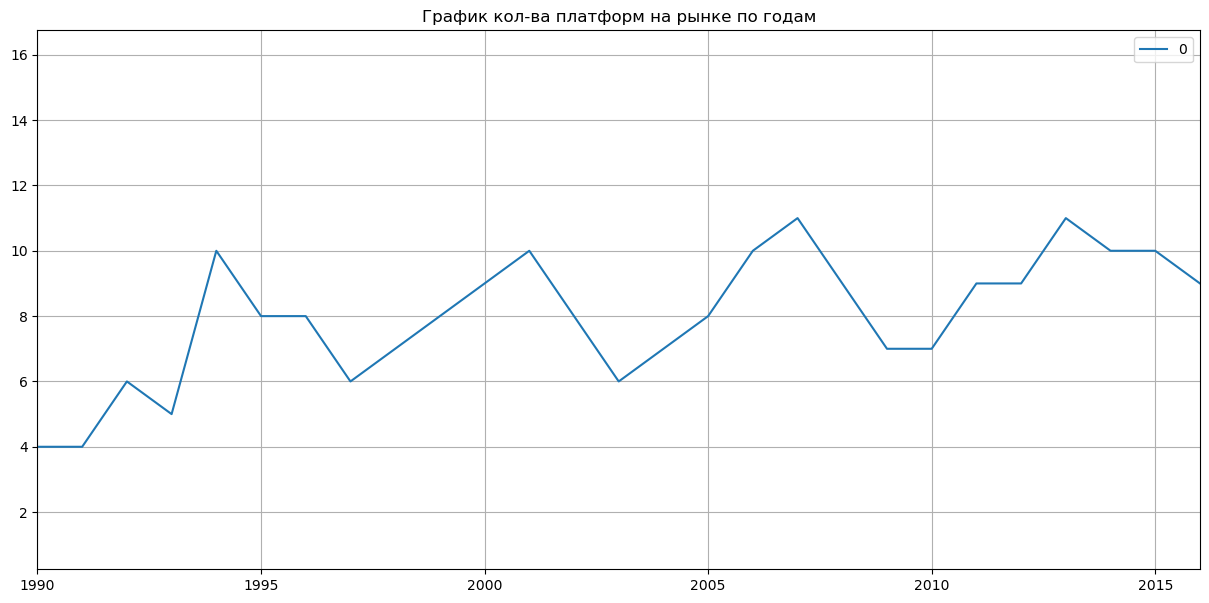

In [124]:
years = sorted(games_df['year_of_release'].unique())
platform_years_dict = {}
for year in years:
    platform_years_dict[year] = len(games_df[games_df['year_of_release'] == year]['platform'].unique())
pd.DataFrame.from_dict(platform_years_dict, orient='index').plot(xlim=[1990, 2016], figsize=(15, 7),grid=True)
plt.title('График кол-ва платформ на рынке по годам')
plt.show()

**Вывод**: Видим, что с середины 1990х на рынке постоянно находится 6-11 платформ. Их количество меняется с периодичностью. Поэтому предположение, что пик рынка 2007-2009г связан с количеством плаатформ, неверен 

### Продажи по платформам

Посмотрим, какие платформы самые продающие

In [125]:
total_platform_pivot = (games_df
                        .pivot_table(index='platform', values='total_sales', aggfunc='sum')
                        .sort_values(by='total_sales', ascending=False)
                        .head(10)
)
total_platform_pivot

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


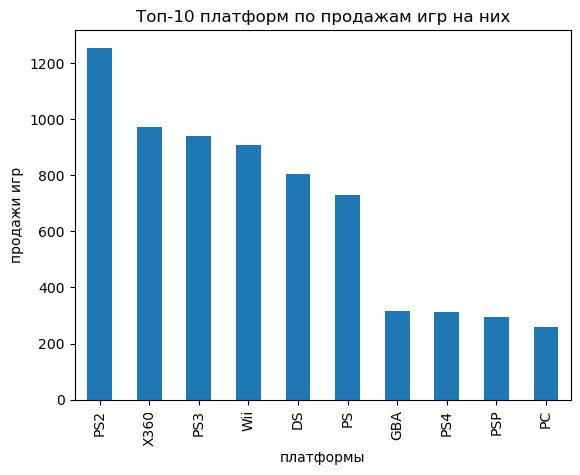

In [126]:
total_platform_pivot.plot(kind='bar', legend=False);
plt.title('Топ-10 платформ по продажам игр на них')
plt.xlabel('платформы')
plt.ylabel('продажи игр')
plt.show()

**Вывод** Самыми продающими платформами за всё время были **PS2, XBox360, PS3, Wii, DS**

### Жизненный цикл платформ

Отобразим распределение продаж этого топа по годам

In [127]:
small_year = [1900, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993]
top10_platform  = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC'] #top10
top5_platform = ['PS2', 'X360', 'PS3', 'Wii', 'DS']
all_platform = games_df['platform'].unique() #все платформы
ntop10 = np.setdiff1d(all_platform, top10_platform) #не входящие в топ (для удаления)
platform_year_pivot = (games_df
                       .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
                       .fillna(0)
                       .drop(ntop10, axis=1)
                       .drop(small_year, axis=0)
)
platform_year_pivot

platform,DS,GBA,PC,PS,PS2,PS3,PS4,PSP,Wii,X360
year_of_release,,,,,,,,,,
1994,0.00,0.00,12.87,6.03,0.00,0.00,0.00,0.00,0.00,0.00
1995,0.00,0.00,4.22,35.96,0.00,0.00,0.00,0.00,0.00,0.00
1996,0.00,0.00,10.58,94.70,0.00,0.00,0.00,0.00,0.00,0.00
1997,0.00,0.00,11.27,136.17,0.00,0.00,0.00,0.00,0.00,0.00
1998,0.00,0.00,3.26,169.49,0.00,0.00,0.00,0.00,0.00,0.00
1999,0.00,0.00,4.74,144.53,0.00,0.00,0.00,0.00,0.00,0.00
2000,0.00,0.07,4.66,96.37,39.17,0.00,0.00,0.00,0.00,0.00
2001,0.00,61.53,5.47,35.59,166.43,0.00,0.00,0.00,0.00,0.00
2002,0.00,74.16,8.57,6.67,205.38,0.00,0.00,0.00,0.00,0.00


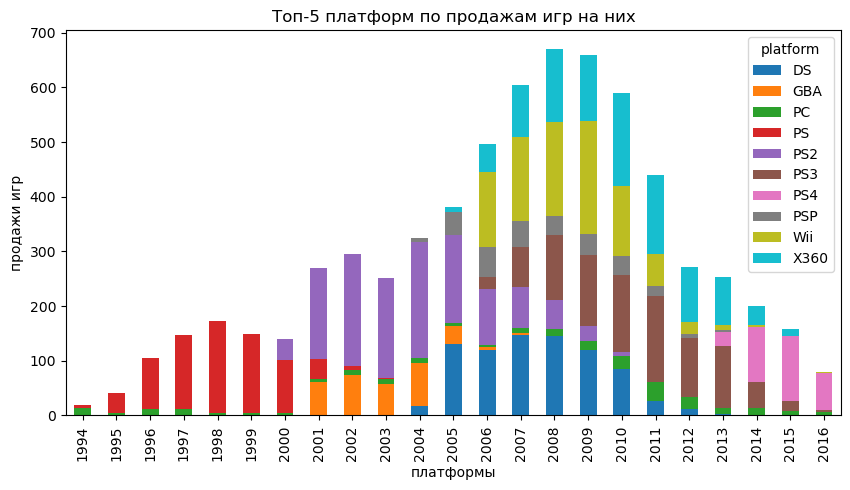

In [128]:
platform_year_pivot.plot.bar(stacked= True, figsize = (10, 5))
plt.title('Топ-5 платформ по продажам игр на них')
plt.xlabel('платформы')
plt.ylabel('продажи игр')
plt.show()

По графику можно заметить, что платформы в какой-то момент приходят на рынок, а потом через несколько лет уходят. Так например продажи игр PS2 появились в 2000 году и прекратились в 2010. Определим по общим данным среднюю продолжительность жизни платформы

In [129]:
temp_df = games_df.copy()
temp_df = temp_df[temp_df['year_of_release'] != 1900]
life_cycle_pivot = temp_df.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max'])
life_cycle_pivot.columns = ['min', 'max']
life_cycle_pivot['period'] = life_cycle_pivot['max'] - life_cycle_pivot['min']
life_cycle_pivot    

,min,max,period
platform,,,
2600,1980,1989,9
3DO,1994,1995,1
3DS,2011,2016,5
DC,1998,2008,10
DS,1985,2013,28
GB,1988,2001,13
GBA,2000,2007,7
GC,2001,2007,6
GEN,1990,1994,4


In [130]:
life_cycle_pivot['period'].describe()

count    31.000000
mean      7.612903
std       6.998464
min       0.000000
25%       3.000000
50%       6.000000
75%      10.000000
max      31.000000
Name: period, dtype: float64

**Вывод** Средний жизненный цикл платформы - 7.6лет, медианное значение - 6 лет

In [131]:
(temp_df[temp_df['platform'] == 'DS']
    .pivot_table(index='year_of_release', values='name', aggfunc='count')
)

,name
year_of_release,
1985,1
2004,23
2005,118
2006,201
2007,376
2008,492
2009,403
2010,323
2011,153


Nintendo DS была выпущена в конце 2004г. Поэтому запись от 1985г - явная ошибка

In [132]:
games_df[(games_df['platform'] == 'DS') & (games_df['year_of_release'] == 1985)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15955,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,N.A.,0.02


In [133]:
games_df = games_df.drop(15955, axis=0)

In [134]:
temp_df = games_df.copy()
temp_df = temp_df[(temp_df['year_of_release'] != 1900) & (temp_df['platform'] != 'PC')]
life_cycle_pivot = temp_df.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max'])
life_cycle_pivot.columns = ['min', 'max']
life_cycle_pivot['period'] = life_cycle_pivot['max'] - life_cycle_pivot['min']
life_cycle_pivot   

,min,max,period
platform,,,
2600,1980,1989,9
3DO,1994,1995,1
3DS,2011,2016,5
DC,1998,2008,10
DS,2004,2013,9
GB,1988,2001,13
GBA,2000,2007,7
GC,2001,2007,6
GEN,1990,1994,4


In [135]:
life_cycle_pivot['period'].describe()

count    30.000000
mean      6.200000
std       3.933937
min       0.000000
25%       3.000000
50%       6.000000
75%       9.750000
max      13.000000
Name: period, dtype: float64

Из-за того что убрали аномалии средняя продолжительность жизни платформы сильно снизилась с 7.6лет до 6.2лет. Медианное значение не изменилось - 6лет

### Актуальные платформы

Определим  список актуальных платформ, которые появились на рынке в 2010г и после

In [136]:
life_cycle_pivot[life_cycle_pivot['min'] >= 2010]

,min,max,period
platform,,,
3DS,2011,2016,5
PS4,2013,2016,3
PSV,2011,2016,5
WiiU,2012,2016,4
XOne,2013,2016,3


Это **3DS, PS4, PSVita, WiiU и XBoxOne**

Построим графики продаж для каждой из актуальных платформ

In [137]:
(games_df[(games_df['platform'] == '3DS') & (games_df['year_of_release'] != 1900)]
        .groupby('year_of_release').count()
        #.plot(kind='bar', figsize = (10, 5))
    )

,name,platform,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
year_of_release,,,,,,,,,,,
2011,116,116,116,116,116,116,116,62,57,116,116
2012,93,93,93,93,93,93,93,33,34,93,93
2013,91,91,91,91,91,91,91,20,25,91,91
2014,80,80,80,80,80,80,80,22,22,80,80
2015,86,86,86,86,86,86,86,19,21,86,86
2016,46,46,46,46,46,46,46,10,12,46,46


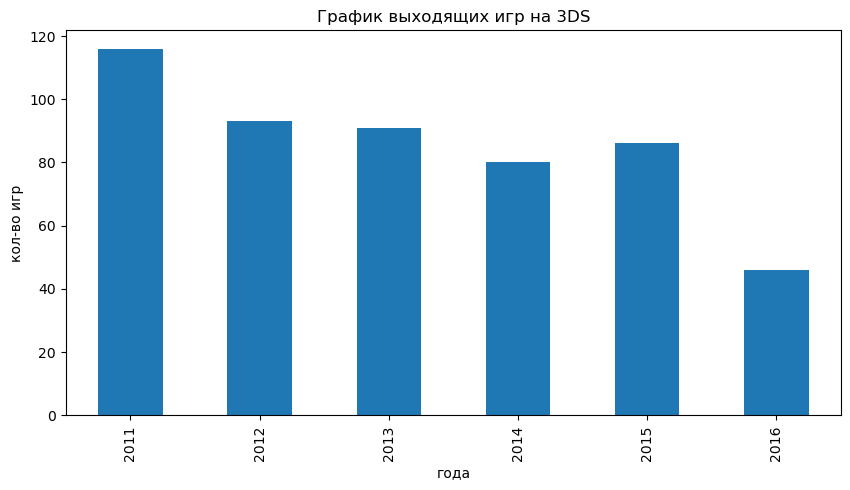

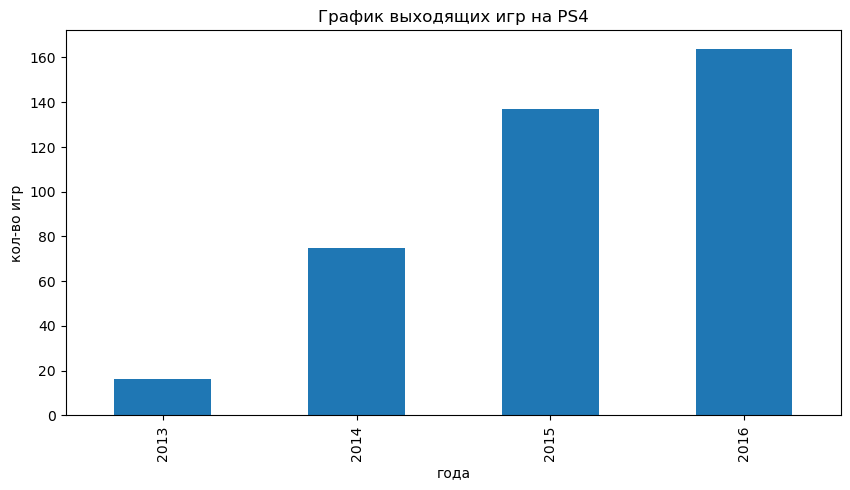

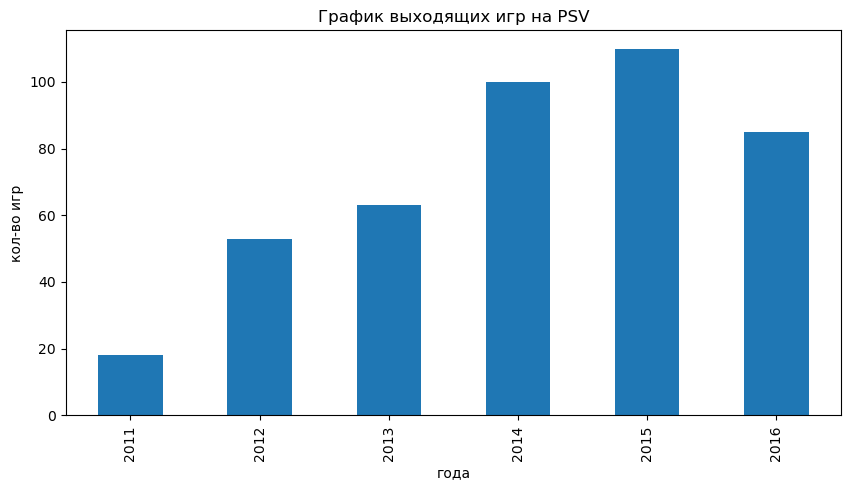

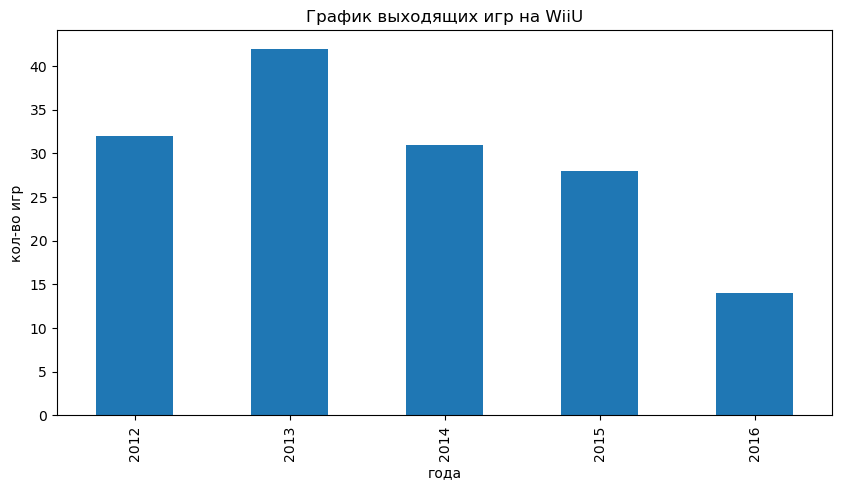

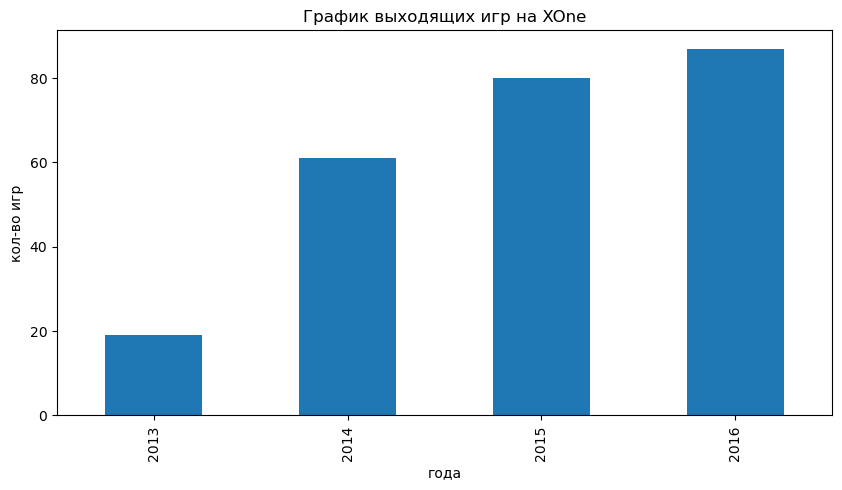

In [138]:
actual_platform = ['3DS', 'PS4', 'PSV', 'WiiU', 'XOne']
for platform in actual_platform:
    (games_df[(games_df['platform'] == platform) & (games_df['year_of_release'] != 1900)]
        .groupby('year_of_release')['total_sales'].count()
        .plot(kind='bar', figsize = (10, 5))
    )
    plt.title('График выходящих игр на ' + platform)
    plt.xlabel('года')
    plt.ylabel('кол-во игр')
    plt.show()

Наиболее актуальными платформами, которые не перевалили через пик жизненного цикла, являются PS4 и XBoxOne.

Построим так же графики суммарных продаж игр, выпущенных по годам

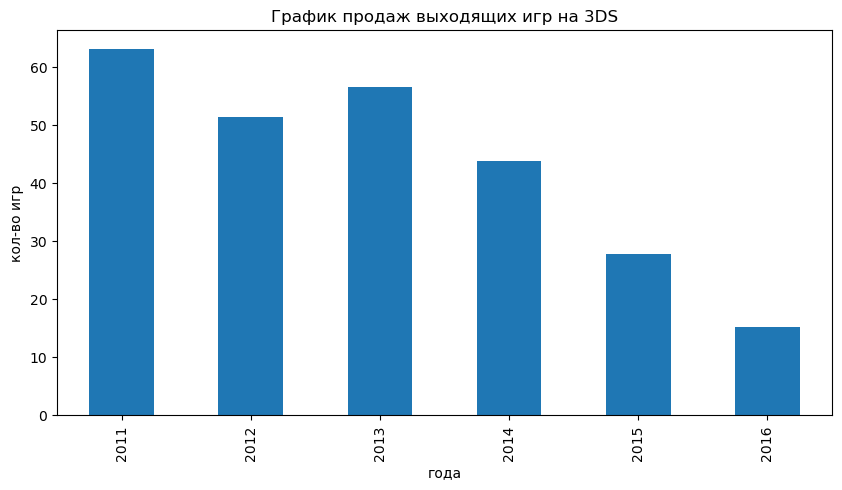

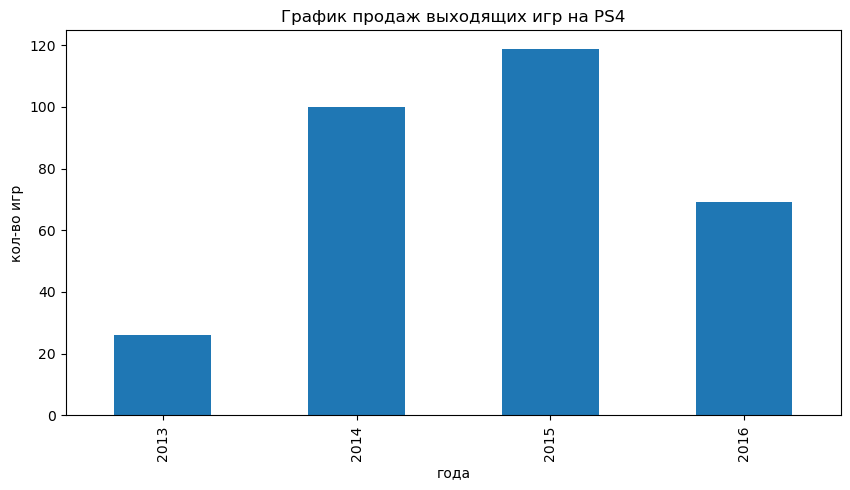

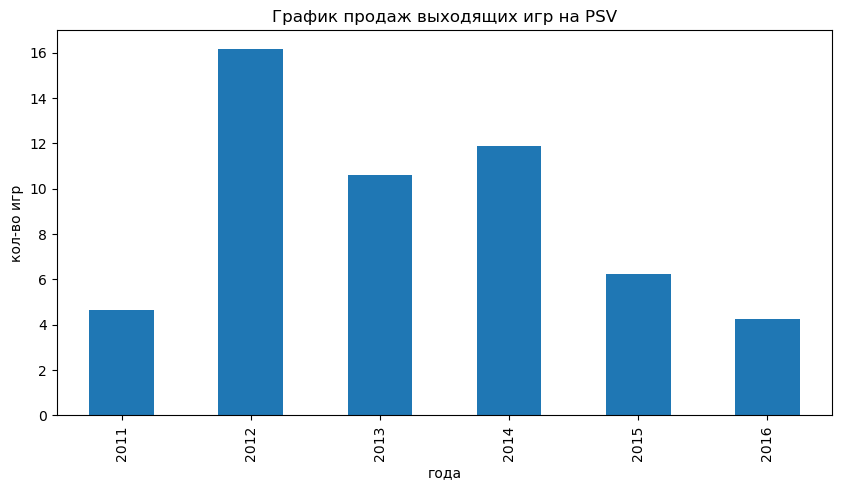

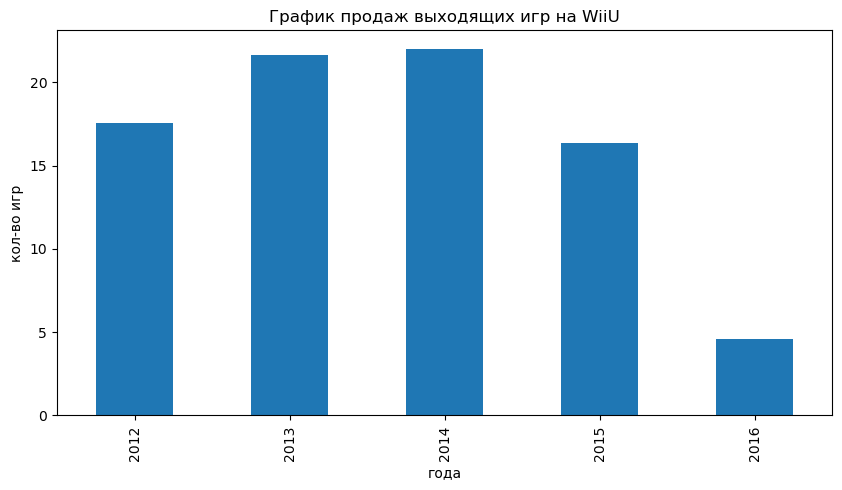

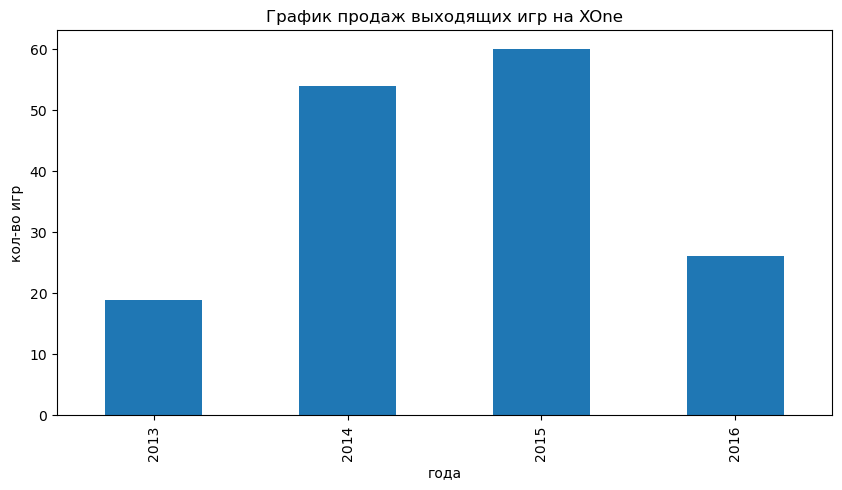

In [139]:
for platform in actual_platform:
    (games_df[(games_df['platform'] == platform) & (games_df['year_of_release'] != 1900)]
        .groupby('year_of_release')['total_sales'].sum()
        .plot(kind='bar', figsize = (10, 5))
    )
    plt.title('График продаж выходящих игр на ' + platform)
    plt.xlabel('года')
    plt.ylabel('кол-во игр')
    plt.show()

Видим, что в 2016 продажи упали на всех платформах. Но это связано с тем, что данные за этот год неполные и данные будут меняться, и статистика по ним пока неполная. Поэтому в прогнозах мы будем ориентироваться на предыдущие графики

Наиболее актуальными платформами, которые не перевалили через пик жизненного цикла, являются **PS4**, **XBoxOne** и **PSVita**. На эти платформы нужно обратить наибольшее внимание. Жизненный цикл 3DS и WiiU подходит к концу, продажи начинают падать уже с 2014-2015гг, но за неполный 2016г игр на **3DS** продались тиражом свыше 15млн копий, очень вероятно, что и в 2017г продажи на этой платформе будут достаточновысокими

Определим платформы, на которых в прошлом году выходили игры

In [140]:
platform2016 = games_df[games_df['year_of_release'] == 2016]['platform'].unique()

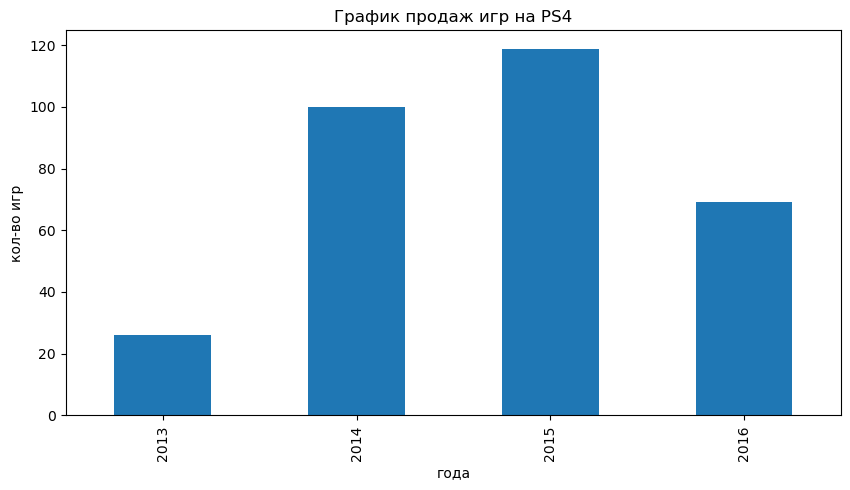

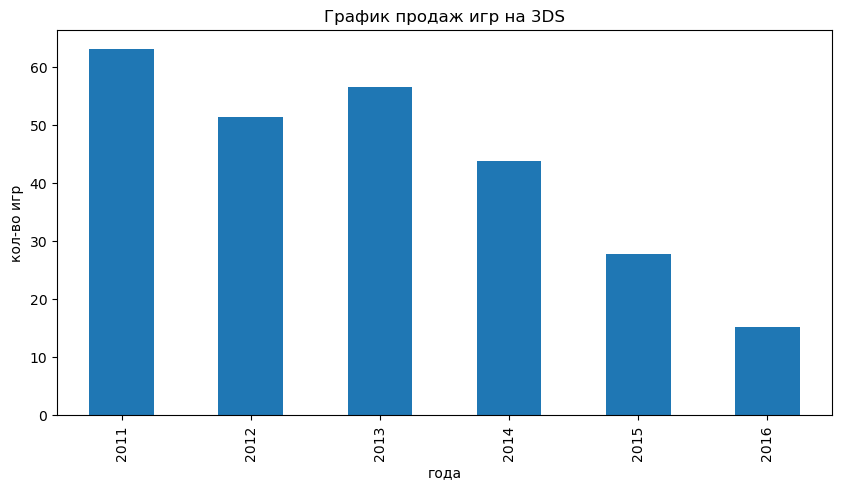

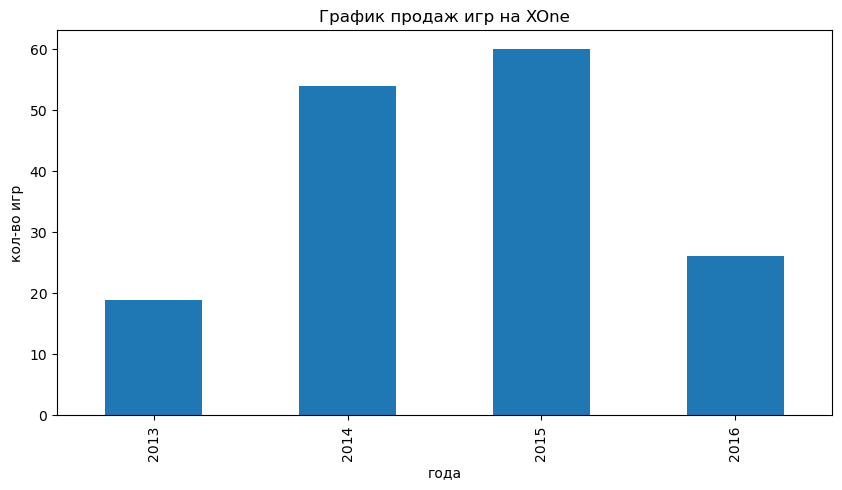

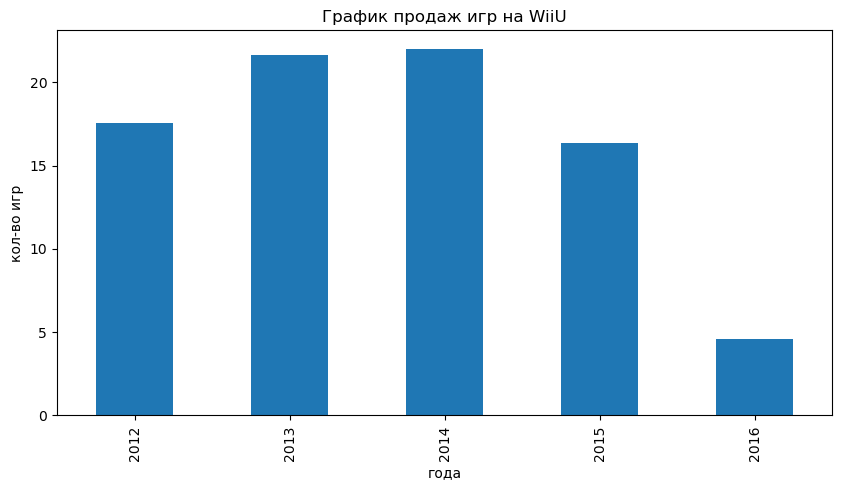

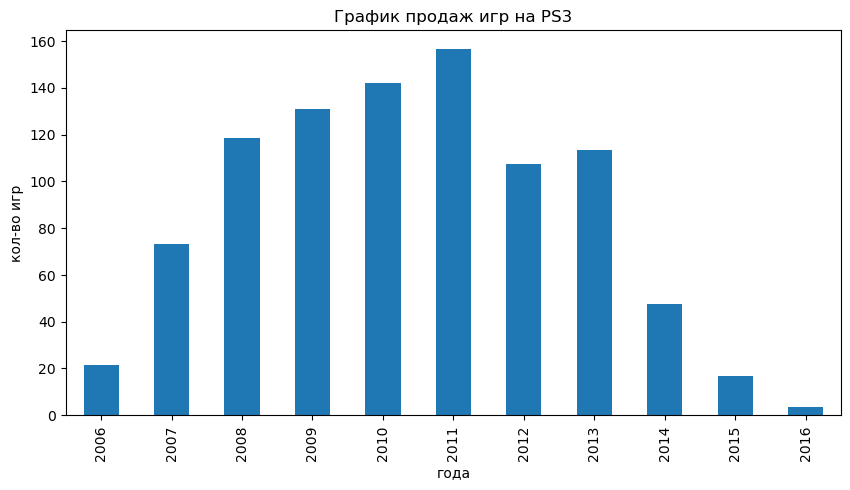

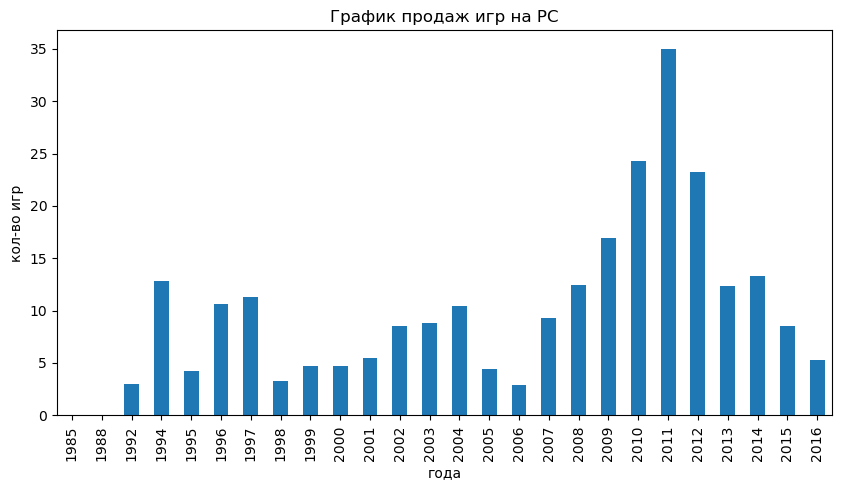

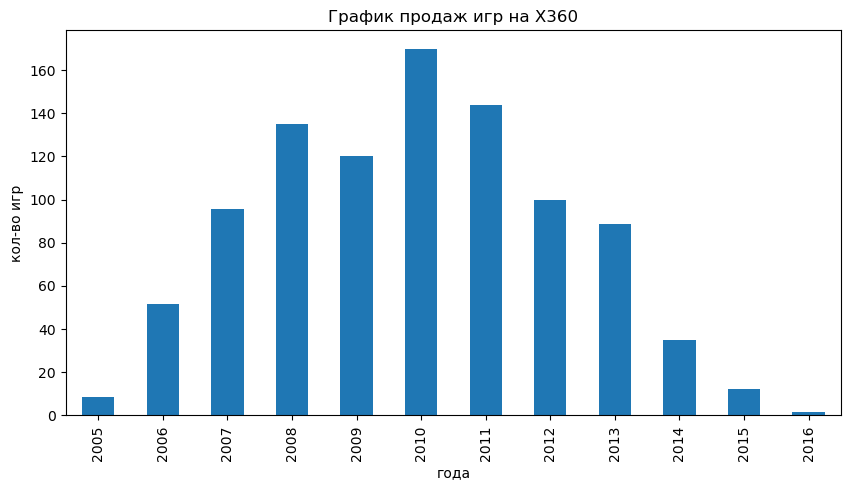

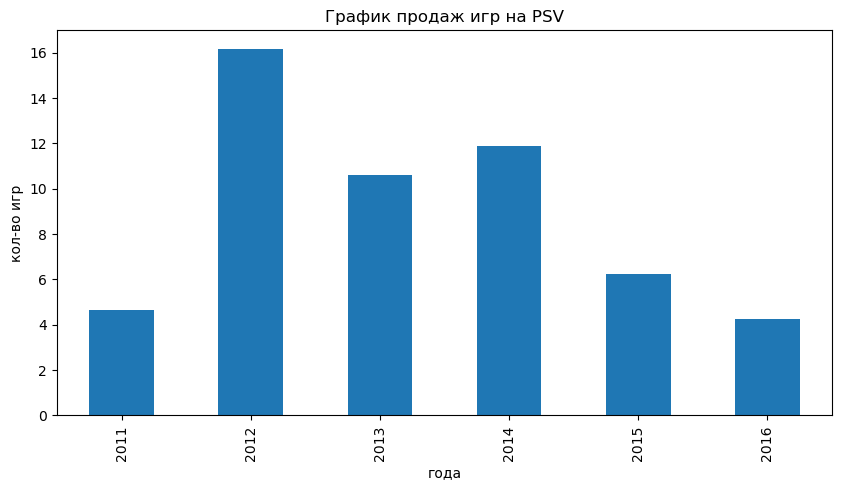

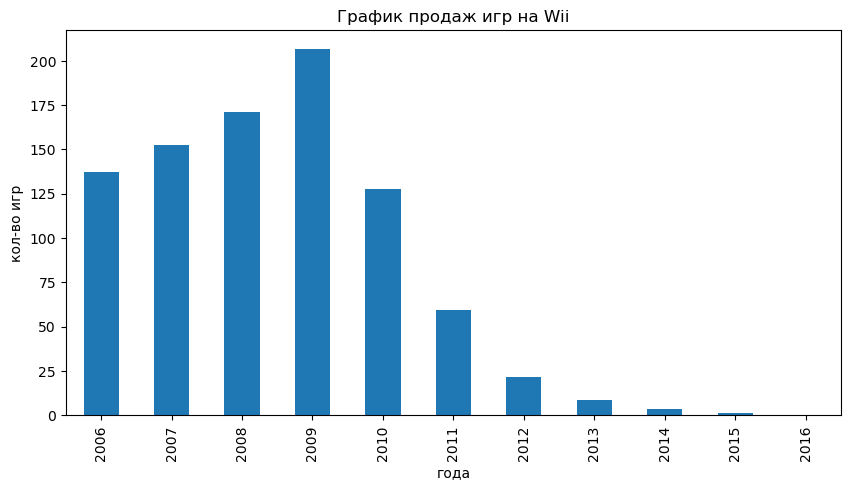

In [141]:
for platform in platform2016:
    (games_df[(games_df['platform'] == platform) & (games_df['year_of_release'] != 1900)]
        .groupby('year_of_release')['total_sales'].sum()
        .plot(kind='bar', figsize = (10, 5))
    )
    plt.title('График продаж игр на ' + platform)
    plt.xlabel('года')
    plt.ylabel('кол-во игр')
    plt.show()

Отдельно стоит отметить только ПК. Продажи падают с 2011г, но всё-равно на достаточн высоком уровне.

**Вывод** Наиболее актуальными платформами, которые не перевалили через пик жизненного цикла, являются **PS4**, **XBoxOne** и **PSVita**. На эти платформы нужно обратить наибольшее внимание. Жизненный цикл 3DS и WiiU подходит к концу, продажи начинают падать уже с 2014-2015гг, но за неполный 2016г игр на **3DS** продались тиражом свыше 15млн копий, очень вероятно, что и в 2017г продажи на этой платформе будут достаточновысокими. Так же стоит отметить только **PC**. Продажи падают с 2011г, но всё-равно на достаточн высоком уровне.

### Глобальные продажи игр  по платформам

Постройте усиковую диаграмму по глобальным продажам игр в разбивке по платформам.

Для начала создадим датафрейм с информацией за актуальный период

In [142]:
act_data = games_df[games_df['year_of_release'] > 2013]

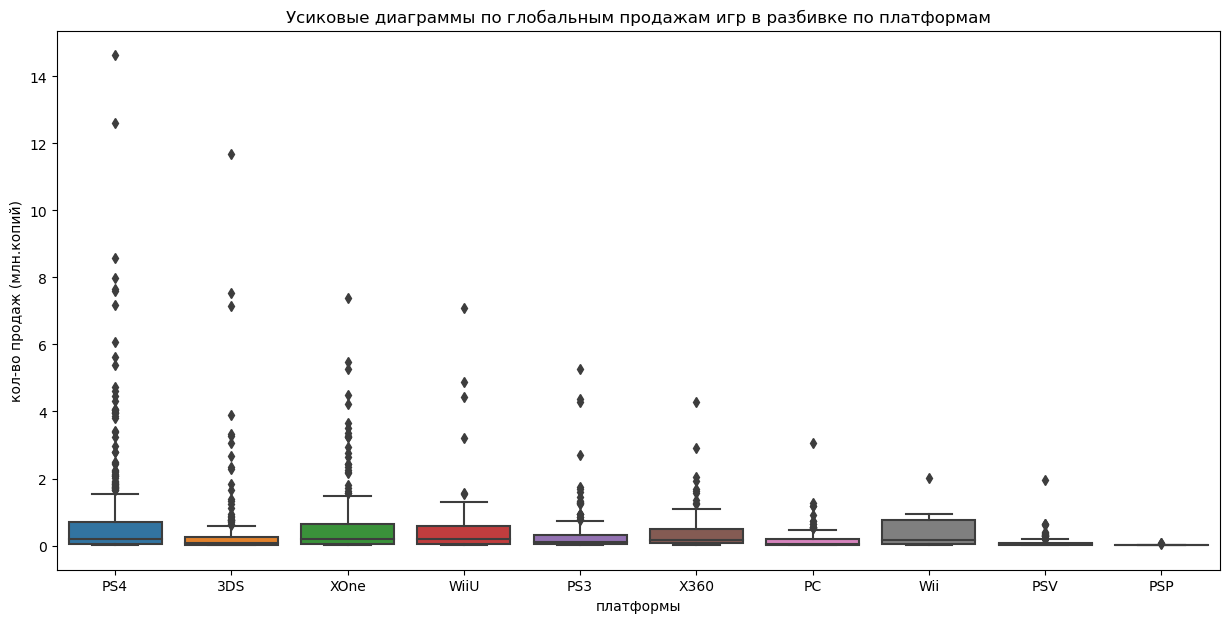

In [143]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(data=act_data,  y='total_sales', x='platform')
plt.title('Усиковые диаграммы по глобальным продажам игр в разбивке по платформам')
plt.xlabel('платформы')
plt.ylabel('кол-во продаж (млн.копий)')
plt.show()

На графиках видим много выбросов выше 4 млн.копий.  Посмотрим диаграммы без этих выбросов

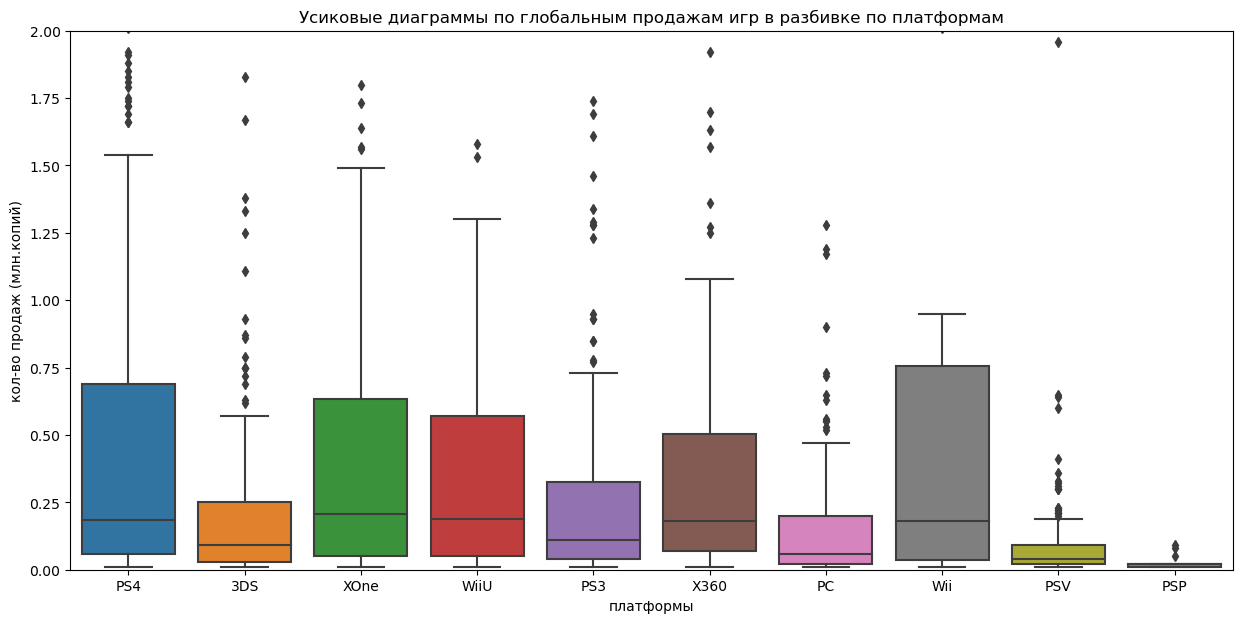

In [144]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(data=act_data,  y='total_sales', x='platform')
plt.ylim(0,2) #исправил
plt.title('Усиковые диаграммы по глобальным продажам игр в разбивке по платформам')
plt.xlabel('платформы')
plt.ylabel('кол-во продаж (млн.копий)')
plt.show()

In [145]:
(act_data
 .pivot_table(index='platform', values='total_sales', aggfunc='median')
 .sort_values(by='total_sales', ascending=False)
)

,total_sales
platform,
XOne,0.205
WiiU,0.190
PS4,0.185
Wii,0.180
X360,0.180
PS3,0.110
3DS,0.090
PC,0.060
PSV,0.040


In [146]:
act_data[act_data['platform'] == 'XOne']['total_sales'].describe()

count    228.000000
mean       0.615614
std        1.046513
min        0.010000
25%        0.050000
50%        0.205000
75%        0.632500
max        7.390000
Name: total_sales, dtype: float64

**Вывод** Самые хорошие продажи по играм у XOne. Медианное значение продаж - 205тыс копий, каждая 4я игра продаётся тиражом свыше 635 тыс копий

### Влияние отзывов пользователей и критиков на продажи

Построим графики рассеяния и определим корреляцию отзывов пользователей и критиков на продажи игр для актуальных и популярных платформ

#### Влияние отзывов пользователей для актуальных платформ

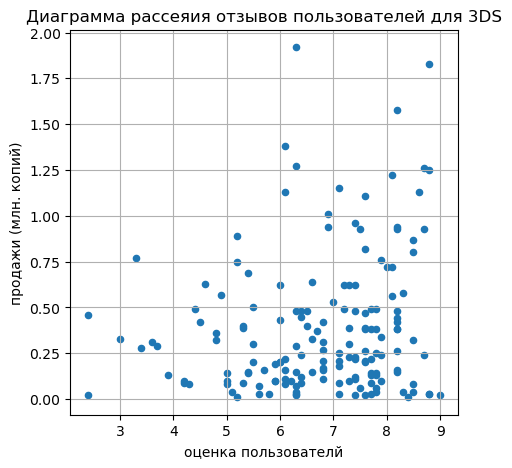

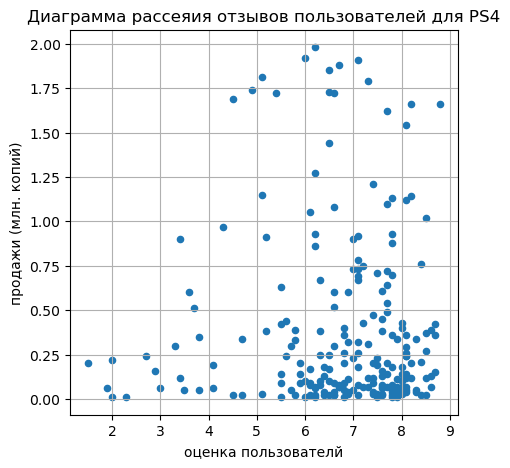

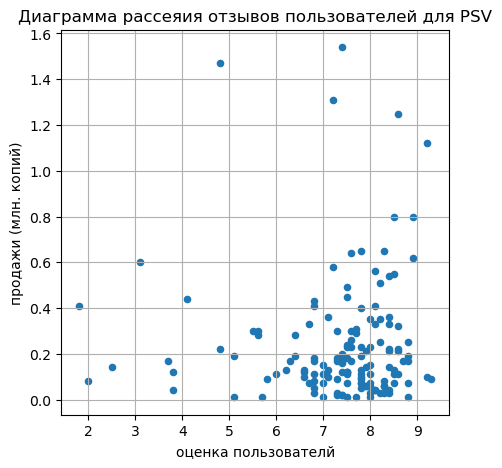

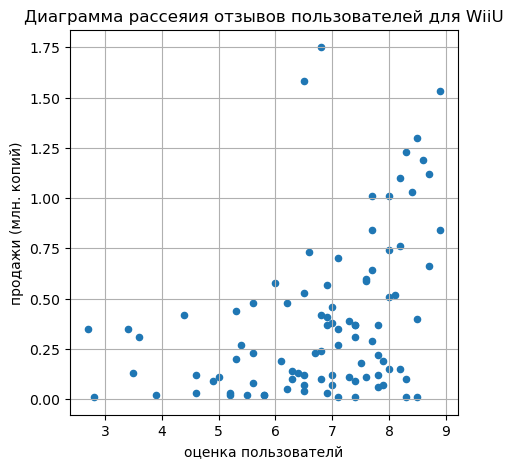

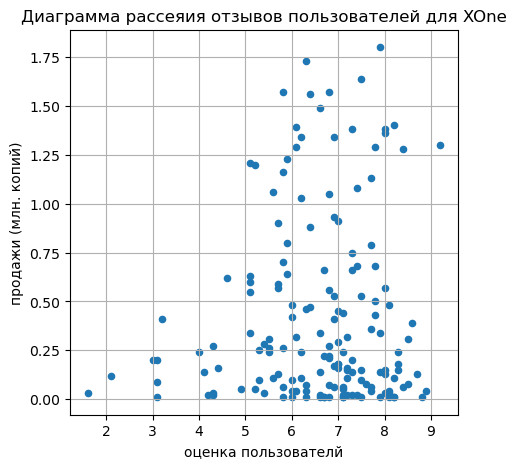

In [147]:
for platform in actual_platform:
    (games_df[(games_df['platform'] == platform) & (games_df['total_sales'] < 2)]
     .plot(x='user_score', y='total_sales', kind='scatter', grid=True, figsize=(5,5))
    )
    plt.title('Диаграмма рассеяия отзывов пользователей для ' + platform)
    plt.xlabel('оценка пользователй')
    plt.ylabel('продажи (млн. копий)')
    plt.show()

На диаграммах корреляции не видно. Чтобы убедиться, вычислим коэффициенты Пирсона

In [148]:
userscore_platform_corres = []
for platform in actual_platform:
    userscore_platform_corres.append([
        platform,
        games_df[(games_df['platform'] == platform)]['total_sales']
          .corr(games_df[(games_df['platform'] == platform)]['user_score'])
    ])               
actplatform_userscore_corr_df = pd.DataFrame(userscore_platform_corres)
actplatform_userscore_corr_df.index = actplatform_userscore_corr_df[0]
actplatform_userscore_corr_df = actplatform_userscore_corr_df.drop(0, axis=1)
actplatform_userscore_corr_df.columns = ['users']
actplatform_userscore_corr_df.index.name = 'platform'
actplatform_userscore_corr_df    

,users
platform,
3DS,0.224808
PS4,-0.031957
PSV,0.013580
WiiU,0.400219
XOne,-0.068925


#### Влияние отзывов критиков для актуальных платформ

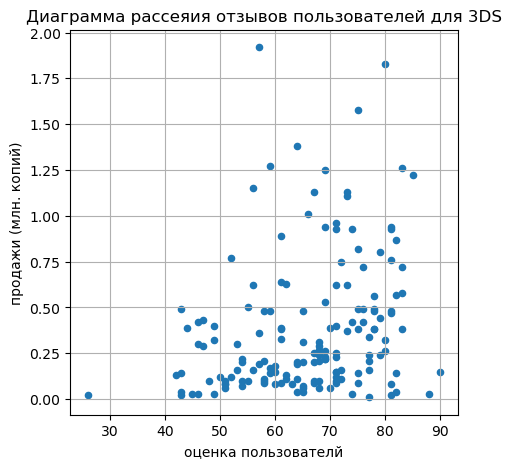

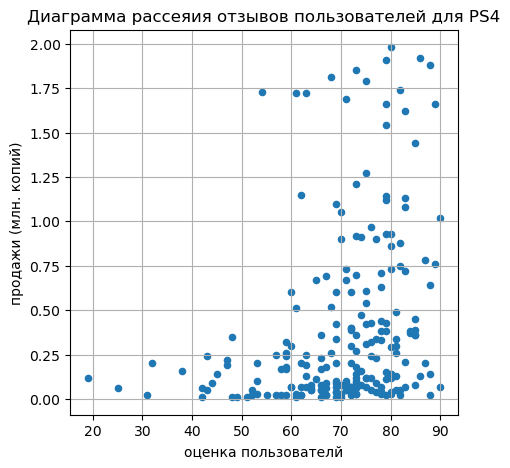

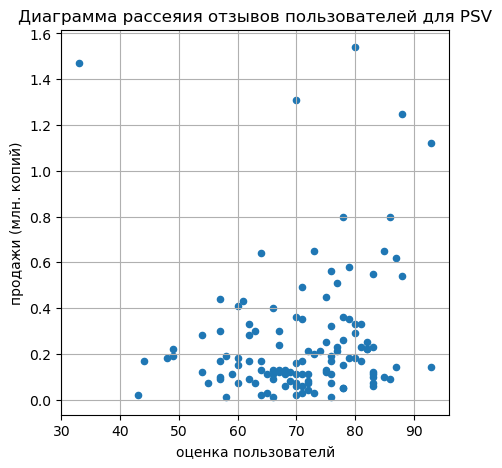

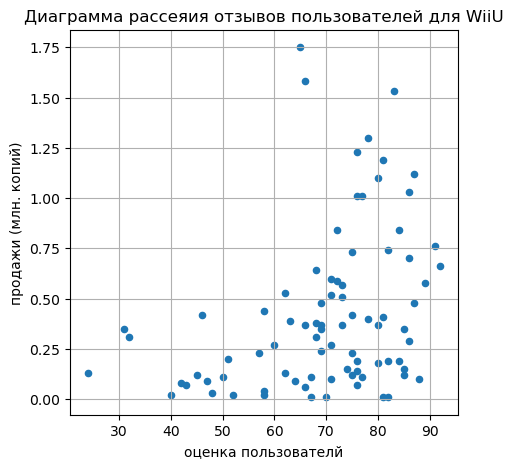

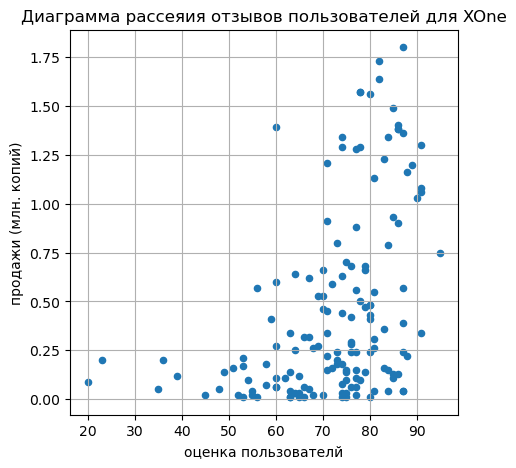

In [149]:
for platform in actual_platform:
    (games_df[(games_df['platform'] == platform) & (games_df['total_sales'] < 2)]
     .plot(x='critic_score', y='total_sales', kind='scatter', grid=True, figsize=(5,5))
    )
    plt.title('Диаграмма рассеяия отзывов пользователей для ' + platform)
    plt.xlabel('оценка пользователй')
    plt.ylabel('продажи (млн. копий)')
    plt.show()

In [150]:
userscore_platform_corres = []
for platform in actual_platform:
    userscore_platform_corres.append([
        platform,
        games_df[(games_df['platform'] == platform)]['total_sales']
          .corr(games_df[(games_df['platform'] == platform)]['critic_score'])
    ])      
actplatform_criticscore_corr_df = pd.DataFrame(userscore_platform_corres)
actplatform_criticscore_corr_df.index = actplatform_criticscore_corr_df[0]
actplatform_criticscore_corr_df = actplatform_criticscore_corr_df.drop(0, axis=1)
actplatform_criticscore_corr_df.columns = ['critics']
actplatform_criticscore_corr_df.index.name = 'platform'
actplatform_criticscore_corr_df

,critics
platform,
3DS,0.349401
PS4,0.406568
PSV,0.131517
WiiU,0.348380
XOne,0.416998


#### Влияние отзывов пользователей и критиков для актуальных платформ

Объеденим предыдущие 2 таблицы

In [151]:
actplatform_userscore_corr_df.merge(actplatform_criticscore_corr_df, on='platform')

,users,critics
platform,,
3DS,0.224808,0.349401
PS4,-0.031957,0.406568
PSV,0.013580,0.131517
WiiU,0.400219,0.348380
XOne,-0.068925,0.416998


#### Влияние отзывов пользователей и критиков для популярных платформ

In [152]:
top_platform_corres = []
for platform in top5_platform:
    top_platform_corres.append([
        platform,
        games_df[(games_df['platform'] == platform)]['total_sales']
          .corr(games_df[(games_df['platform'] == platform)]['user_score']),
        games_df[(games_df['platform'] == platform)]['total_sales']
          .corr(games_df[(games_df['platform'] == platform)]['critic_score'])
    ])              
corr_df = pd.DataFrame(top_platform_corres)
corr_df.index = corr_df[0]
corr_df = corr_df.drop(0, axis=1)
corr_df.columns = ['пользователи', 'критики']
corr_df

,пользователи,критики
0,,
PS2,0.172866,0.395435
X360,0.114459,0.393736
PS3,0.125213,0.432966
Wii,0.112414,0.177560
DS,0.130436,0.236379


#### Промежуточный вывод

Как для актуальных, так и для популярных в прошлом платформ, оценки пользователей никак не влияют на продажи. Влияние оценок критиков несколько большо, но всё-равно незначительно

#### Влияние отзывов ользователей и критиков для всех платформ

In [153]:
all_platform_corres = []
for platform in games_df['platform'].unique():
    all_platform_corres.append([
        platform,
        games_df[(games_df['platform'] == platform)]['total_sales']
          .corr(games_df[(games_df['platform'] == platform)]['user_score']),
        games_df[(games_df['platform'] == platform)]['total_sales']
          .corr(games_df[(games_df['platform'] == platform)]['critic_score'])
    ])              
corr_df = pd.DataFrame(all_platform_corres)
corr_df.index = corr_df[0]
corr_df = corr_df.drop(0, axis=1)
corr_df.columns = ['пользователи', 'критики']
corr_df = corr_df.dropna()
corr_df

,пользователи,критики
0,,
Wii,0.112414,0.177560
DS,0.130436,0.236379
X360,0.114459,0.393736
PS3,0.125213,0.432966
PS2,0.172866,0.395435
GBA,0.100758,0.239101
PS4,-0.031957,0.406568
3DS,0.224808,0.349401
PS,0.297978,0.445640


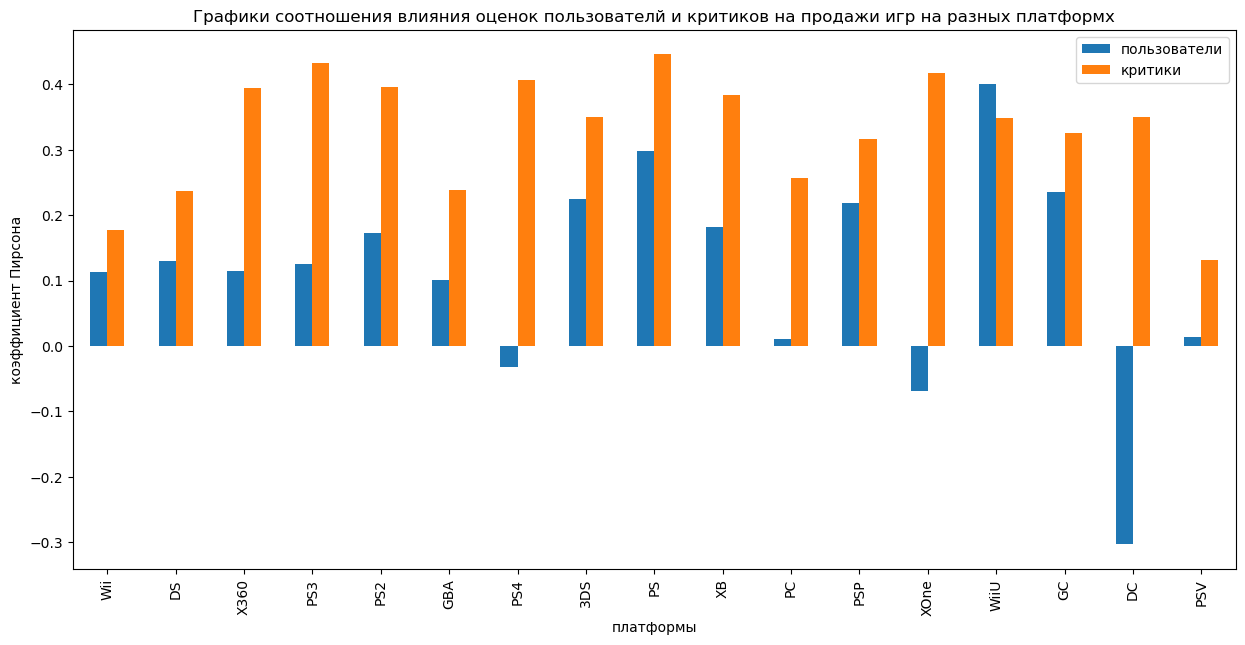

In [154]:
corr_df.plot(kind='bar', figsize=(15, 7))
plt.title('Графики соотношения влияния оценок пользователй и критиков на продажи игр на разных платформх')
plt.xlabel('платформы')
plt.ylabel('коэффициент Пирсона')
plt.show()

#### Вывод

На всех платформах, включая актуальные и наиболее популярные в истории, оценки критиков сильнее влияют на продажи, нежели оценки пользователей. Единственным исключением является Nindendo **WiiU**

### Распределение игр по жанрам

Посмотрим на общее распределение игр по жанрам: их количество и общим продажам

In [155]:
genre_pivot1 = act_data.pivot_table(index='genre', values='name', aggfunc='count')
genre_pivot1.columns = ['count']
genre_pivot2 = act_data.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'mean', 'median'])
genre_pivot2.columns = ['total_sales', 'mean', 'median']
genre_pivot = genre_pivot1.merge(genre_pivot2, on='genre')
genre_pivot.sort_values(by='mean', ascending=False)

,count,total_sales,mean,median
genre,,,,
Shooter,128,170.94,1.335469,0.515
Sports,161,109.48,0.680000,0.180
Platform,38,18.09,0.476053,0.140
Fighting,60,28.22,0.470333,0.125
Role-Playing,221,101.44,0.459005,0.110
Racing,69,27.52,0.398841,0.090
Misc,113,37.55,0.332301,0.090
Action,619,199.36,0.322068,0.090
Simulation,44,13.13,0.298409,0.100


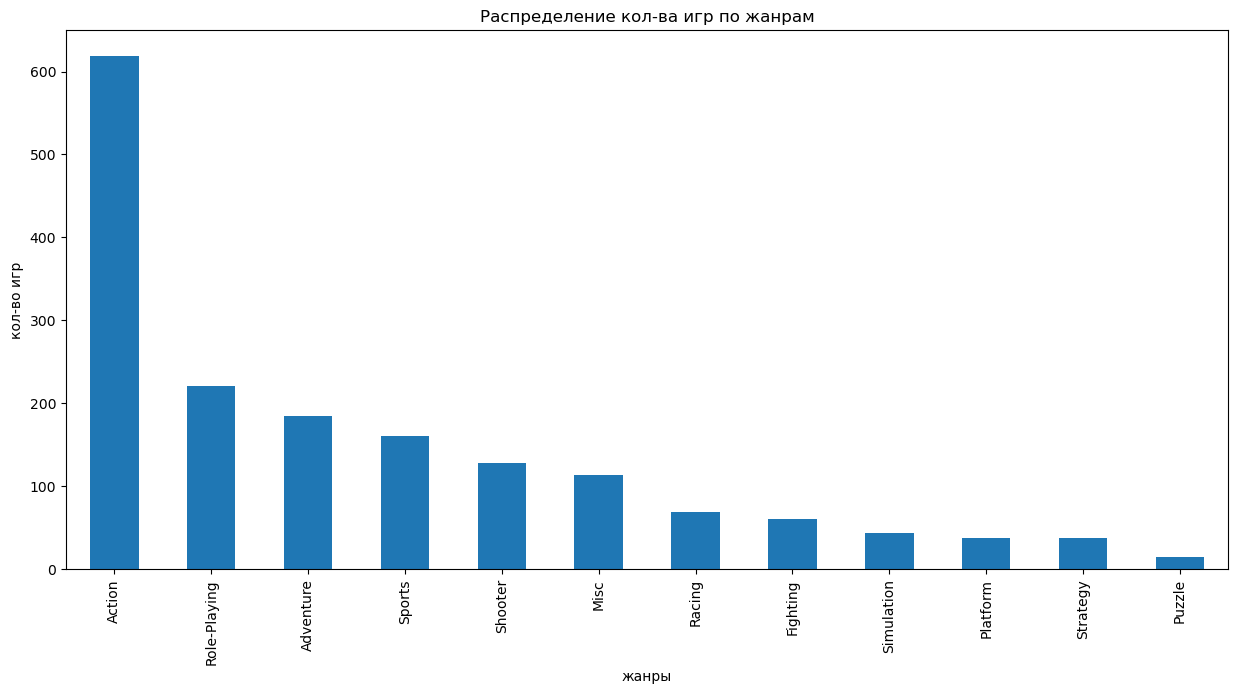

In [156]:
genre_pivot['count'].sort_values(ascending=False).plot(kind='bar', figsize=(15, 7))
plt.title('Распределение кол-ва игр по жанрам')
plt.xlabel('жанры')
plt.ylabel('кол-во игр')
plt.show()

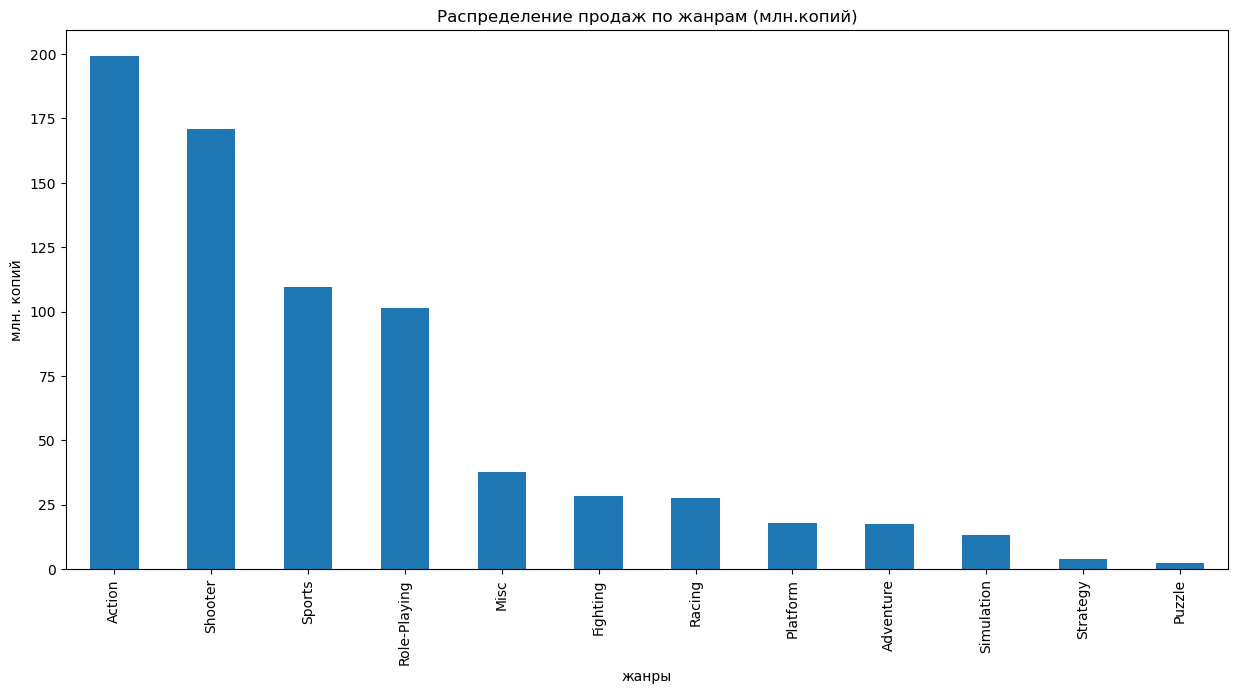

In [157]:
genre_pivot['total_sales'].sort_values(ascending=False).plot(kind='bar', figsize=(15, 7))
plt.title('Распределение продаж по жанрам (млн.копий)')
plt.xlabel('жанры')
plt.ylabel('млн. копий')
plt.show()

**Вывод** Больше всего игр в жанре Action. По этой причине и  суммарные продажи по жанрам здесь самые высокие. Но самыми популярными являются игры в жанре Shooter: в среднем игра продаётся тиражом свыше 1.3млн.копий, медианное значение так же самое большое среди всех жанров, но значительно ниже - 515тыс. копий

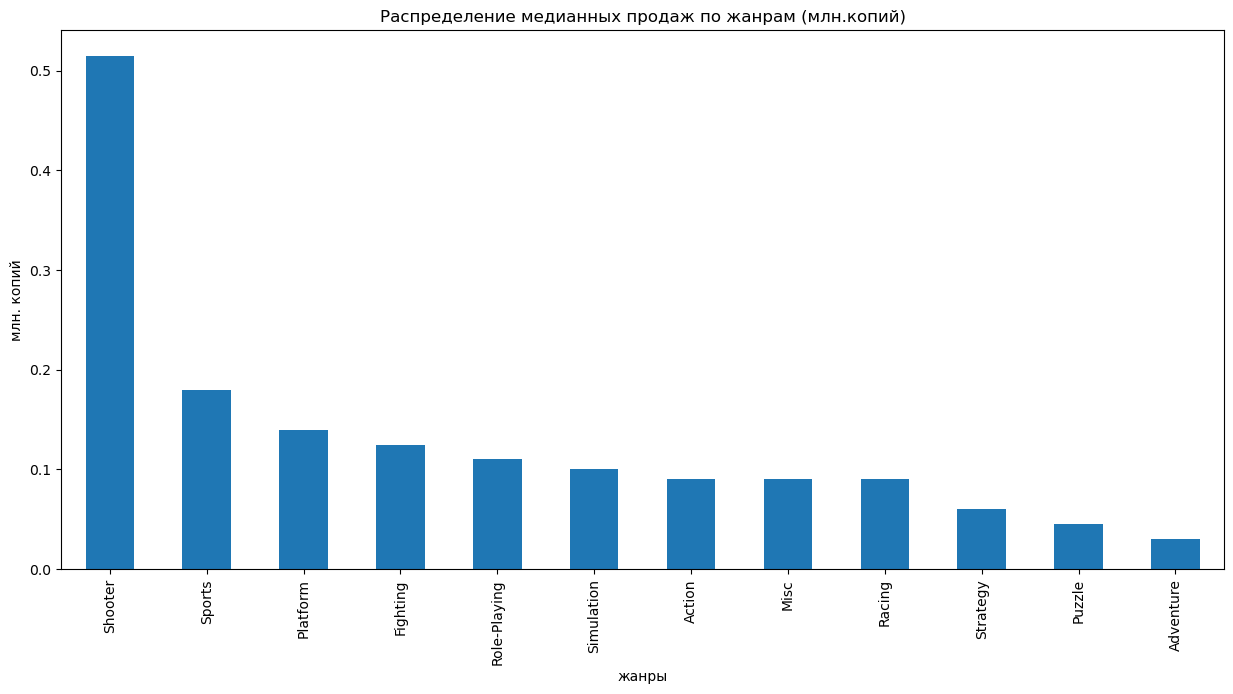

In [158]:
genre_pivot['median'].sort_values(ascending=False).plot(kind='bar', figsize=(15, 7))
plt.title('Распределение медианных продаж по жанрам (млн.копий)')
plt.xlabel('жанры')
plt.ylabel('млн. копий')
plt.show()

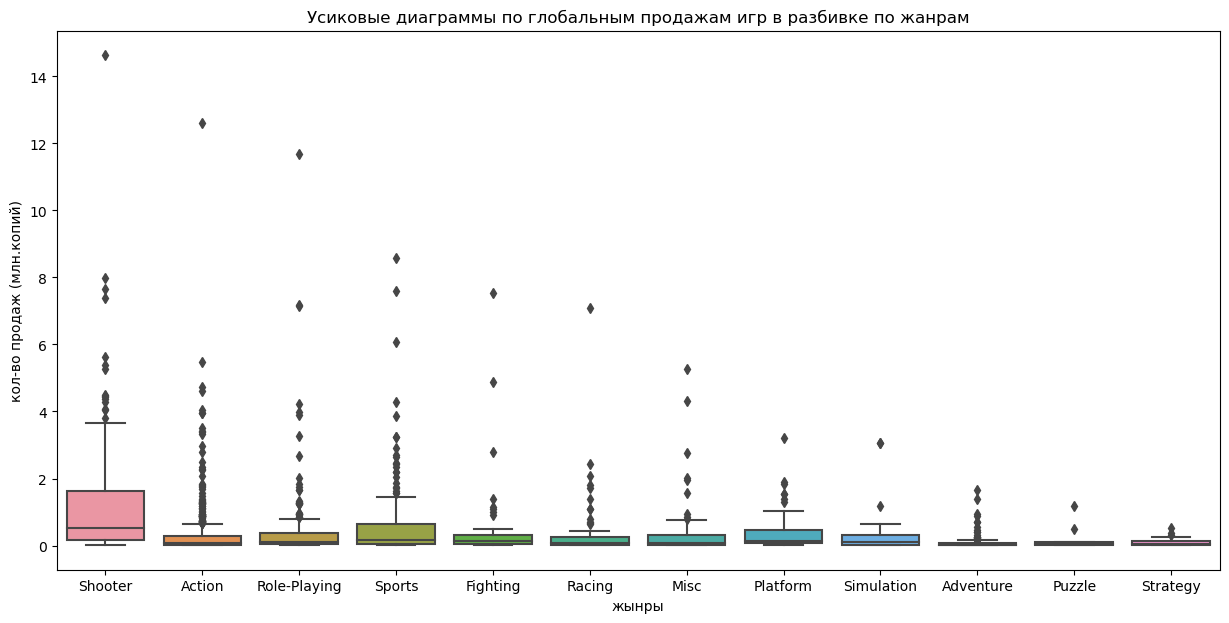

In [159]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(data=act_data,  y='total_sales', x='genre')
plt.title('Усиковые диаграммы по глобальным продажам игр в разбивке по жанрам')
plt.xlabel('жынры')
plt.ylabel('кол-во продаж (млн.копий)')
plt.show()

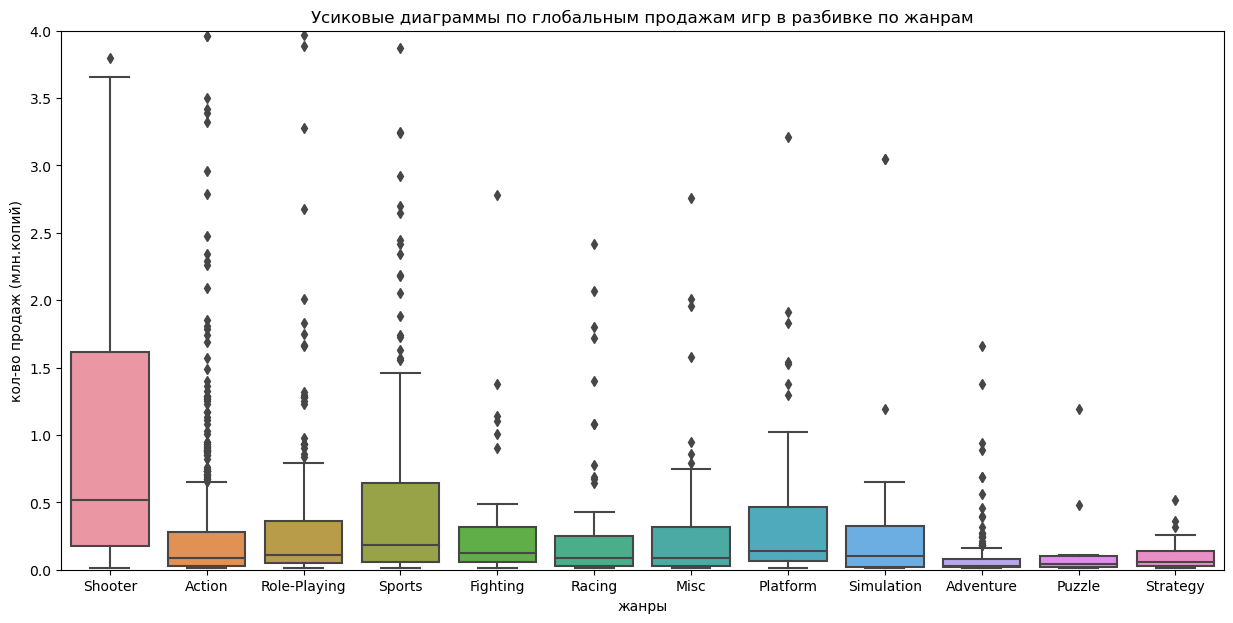

In [160]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(data=act_data,  y='total_sales', x='genre')
plt.ylim(0,4)
plt.title('Усиковые диаграммы по глобальным продажам игр в разбивке по жанрам')
plt.xlabel('жанры')
plt.ylabel('кол-во продаж (млн.копий)')
plt.show()

Определим, какие жанры имеют более длинный ряд успешно продающихся игр. Под успешно продующейся игрой будем считать  игру с продажами выше медианного значения

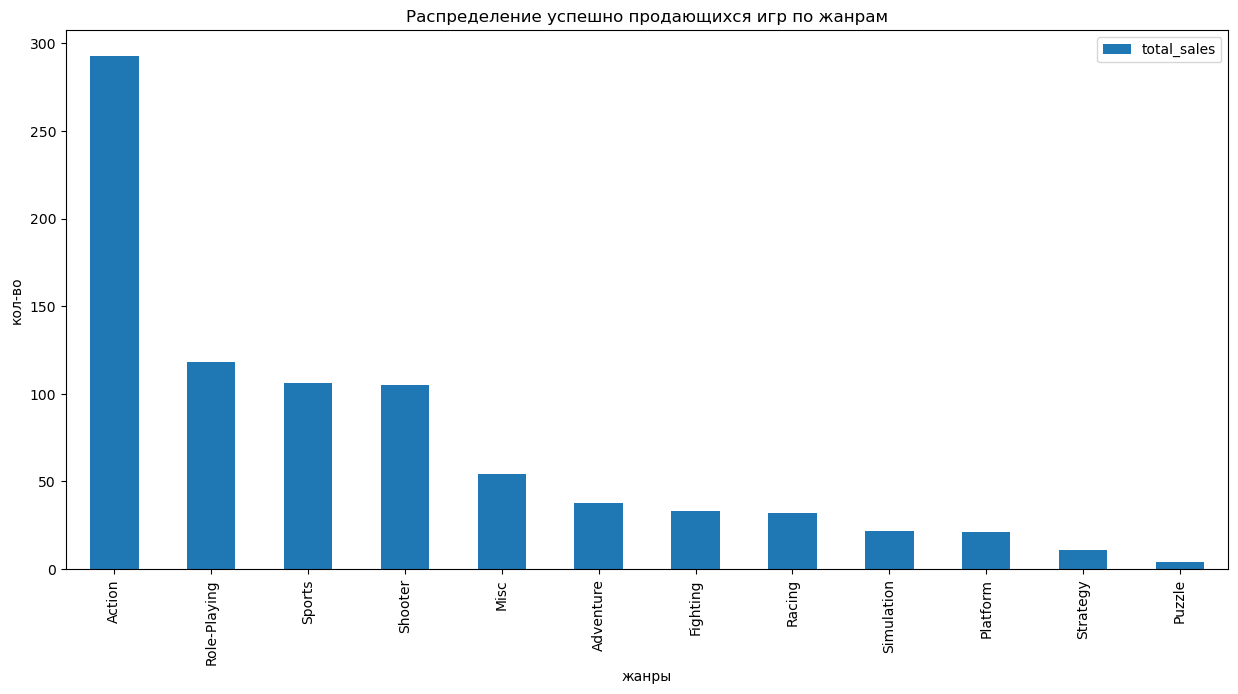

In [161]:
(act_data[act_data['total_sales'] > act_data['total_sales'].median()]
     .pivot_table(index='genre', values='total_sales', aggfunc='count')
     .sort_values(by='total_sales', ascending=False)
     .plot(kind='bar', figsize=(15, 7))
)
plt.title('Распределение успешно продающихся игр по жанрам')
plt.xlabel('жанры')
plt.ylabel('кол-во')
plt.show()

**Вывод** Больше всего игр в жанре Action. По этой причине и  суммарные продажи по жанрам здесь самые высокие. Но самыми популярными являются игры в жанре Shooter: в среднем игра продаётся тиражом свыше 1.3млн.копий, медианное значение так же самое большое среди всех жанров, но значительно ниже - 515тыс. копий

### Выводы исследовательского анализа

* Пик выхода релизов приходится на **2007-2009г**
* Самыми продающими платформами за всё время были **PS2, XBox360, PS3, Wii, DS**
* С середины 1990х на рынке постоянно находится 6-11 платформ одновременно
* Средний жизненный цикл платформы - 6.2лет, медианное значение - 6 лет
* Наиболее актуальными платформами, которые не перевалили через пик жизненного цикла, являются **PS4**, **XBoxOne** и **PSVita**. На эти платформы нужно обратить наибольшее внимание. Жизненный цикл 3DS и WiiU подходит к концу, продажи начинают падать уже с 2014-2015гг, но за неполный 2016г игр на **3DS** продались тиражом свыше 15млн копий, очень вероятно, что и в 2017г продажи на этой платформе будут достаточновысокими. Так же стоит отметить только **PC**. Продажи падают с 2011г, но всё-равно на достаточн высоком уровне.
* Самые хорошие продажи по играм у **XBoxOne**. Медианное значение продаж - 205тыс копий, каждая 4я игра продаётся тиражом свыше 635 тыс копий
* На всех платформах, включая актуальные и наиболее популярные в истории, оценки критиков сильнее влияют на продажи, нежели оценки пользователей. Единственным исключением является Nindendo WiiU
* Больше всего игр в жанре Action. По этой причине и суммарные продажи по жанрам здесь самые высокие. Но самыми популярными являются игры в жанре Shooter: в среднем игра продаётся тиражом свыше 1.3млн.копий, медианное значение так же самое большое среди всех жанров, но значительно ниже - 515тыс. копий

## Портрет пользователя каждого региона

### Топ-5 платформ по регионам

Определим наиболее популярные плптформы в каждом регионе на актуальных данных

In [162]:
region_platform_pivot = (act_data
                         .pivot_table(index='platform', 
                                      values=['na_sales', 'eu_sales', 'jp_sales'], 
                                      aggfunc='sum')
                        )
region_platform_pivot

,eu_sales,jp_sales,na_sales
platform,,,
3DS,16.12,44.24,22.64
PC,17.97,0.00,7.23
PS3,25.54,11.22,22.05
PS4,130.04,15.02,98.61
PSP,0.00,0.36,0.00
PSV,3.53,14.54,2.52
Wii,2.59,0.00,2.08
WiiU,13.15,7.31,19.36
X360,15.49,0.08,28.30


Топ-5 платформ по регионам

In [163]:
regions = ['eu', 'jp', 'na']
eu_top_platform = region_platform_pivot.sort_values(by='eu_sales', ascending=False).head(5).index
jp_top_platform = region_platform_pivot.sort_values(by='jp_sales', ascending=False).head(5).index
na_top_platform = region_platform_pivot.sort_values(by='na_sales', ascending=False).head(5).index
top_platform = pd.DataFrame(
    data=[eu_top_platform, jp_top_platform, na_top_platform], 
    index= regions, 
    columns=[1, 2, 3, 4, 5])
top_platform

,1,2,3,4,5
eu,PS4,XOne,PS3,PC,3DS
jp,3DS,PS4,PSV,PS3,WiiU
na,PS4,XOne,X360,3DS,PS3


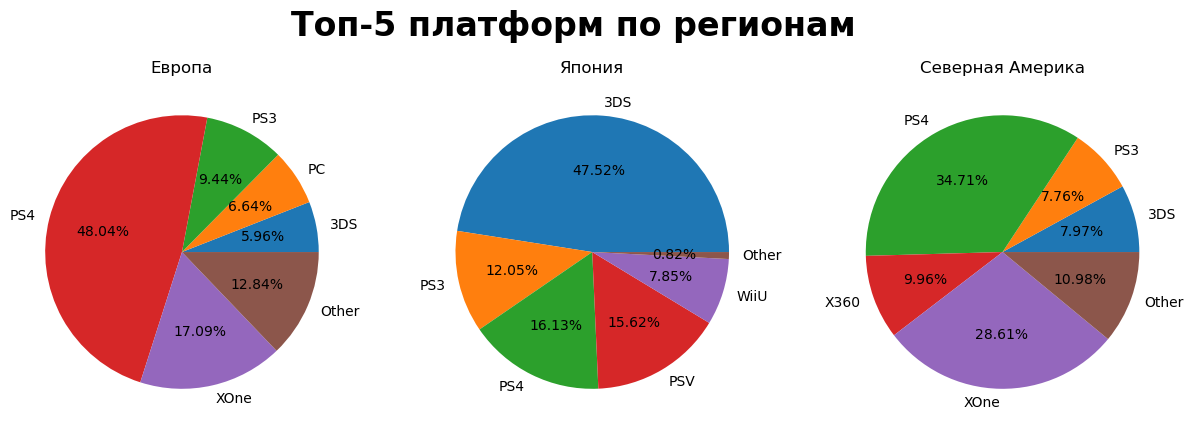

In [164]:
#EU_Sales
fig, axes = plt.subplots(1, 3, figsize = (15,5))
fig.suptitle('Топ-5 платформ по регионам', fontsize = 24, fontweight='bold')

plt.subplot(1, 3, 1)
eu_pivot = (act_data[act_data['platform'].isin(eu_top_platform)]
            .pivot_table(index='platform', values='eu_sales', aggfunc='sum')
)
eu_pivot.loc['Other'] = act_data[act_data['platform'].isin(eu_top_platform) == False]['eu_sales'].sum()
eu_pivot['eu_sales'].plot(kind='pie', autopct='%1.2f%%',
                         title='Европа', ylabel='')
#JP_Sales
plt.subplot(1, 3, 2)
jp_pivot = (act_data[act_data['platform'].isin(jp_top_platform)]
            .pivot_table(index='platform', values='jp_sales', aggfunc='sum')
)
jp_pivot.loc['Other'] = act_data[act_data['platform'].isin(jp_top_platform) == False]['jp_sales'].sum()
jp_pivot['jp_sales'].plot(kind='pie', autopct='%1.2f%%',
                         title='Япония', ylabel='')
#NA_Sales
plt.subplot(1, 3, 3)
na_pivot = (act_data[act_data['platform'].isin(na_top_platform)]
            .pivot_table(index='platform', values='na_sales', aggfunc='sum')
)
na_pivot.loc['Other'] = act_data[act_data['platform'].isin(na_top_platform) == False]['na_sales'].sum()
na_pivot['na_sales'].plot(kind='pie', autopct='%1.2f%%',
                         title='Северная Америка', ylabel='')
plt.show()

**Вывод** 
* В Европе самой популярной платформой является - PS4, далее XOne, PS3, PC и 3DS
* в США самой популярной платформой является PS4, далее XOne, X360, 3DS и PS3
* В Японии самой популярной платформой является 3DS, далее PS4, PSV, PS3 и WiiU

### Топ-5 жанров по регионам

Определим наиболее популярные жанры в каждом регионе на актуальных данных

In [165]:
region_genre_pivot = (act_data
                         .pivot_table(index='genre', 
                                      values=['na_sales', 'eu_sales', 'jp_sales'], 
                                      aggfunc='sum')
                        )
region_genre_pivot

,eu_sales,jp_sales,na_sales
genre,,,
Action,74.68,29.58,72.53
Adventure,6.49,3.60,5.64
Fighting,6.69,6.37,12.43
Misc,12.86,5.61,15.05
Platform,6.80,2.69,6.79
Puzzle,0.52,0.93,0.65
Racing,14.13,1.76,8.74
Role-Playing,28.17,31.16,33.47
Shooter,65.52,4.87,79.02


In [166]:
eu_top_genres = region_genre_pivot.sort_values(by='eu_sales', ascending=False).head(5).index
jp_top_genres = region_genre_pivot.sort_values(by='jp_sales', ascending=False).head(5).index
na_top_genres = region_genre_pivot.sort_values(by='na_sales', ascending=False).head(5).index
top_genres = pd.DataFrame(data=[eu_top_genres, jp_top_genres, na_top_genres], index=['eu', 'jp', 'na'], columns=[1, 2, 3, 4, 5])
top_genres

,1,2,3,4,5
eu,Action,Shooter,Sports,Role-Playing,Racing
jp,Role-Playing,Action,Fighting,Misc,Shooter
na,Shooter,Action,Sports,Role-Playing,Misc


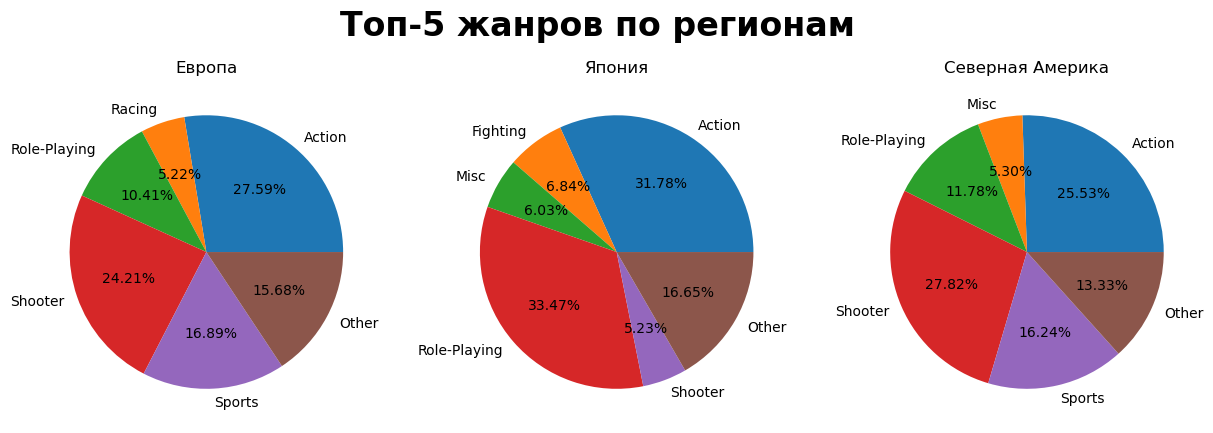

In [167]:
#EU_Sales
fig, axes = plt.subplots(1, 3, figsize = (15,5))
fig.suptitle('Топ-5 жанров по регионам', fontsize = 24, fontweight='bold')

plt.subplot(1, 3, 1)
eu_genre_pivot = (act_data[act_data['genre'].isin(eu_top_genres)]
            .pivot_table(index='genre', values='eu_sales', aggfunc='sum')
)
eu_genre_pivot.loc['Other'] = act_data[act_data['genre'].isin(eu_top_genres) == False]['eu_sales'].sum()
eu_genre_pivot['eu_sales'].plot(kind='pie', autopct='%1.2f%%', figsize=(15,5),
                         title='Европа', ylabel='')
#JP_Sales
plt.subplot(1, 3, 2)
jp_genre_pivot = (act_data[act_data['genre'].isin(jp_top_genres)]
            .pivot_table(index='genre', values='jp_sales', aggfunc='sum')
)
jp_genre_pivot.loc['Other'] = act_data[act_data['genre'].isin(jp_top_genres) == False]['jp_sales'].sum()
jp_genre_pivot['jp_sales'].plot(kind='pie', autopct='%1.2f%%', figsize=(15,5),
                         title='Япония', ylabel='')
#NA_Sales
plt.subplot(1, 3, 3)
na_genre_pivot = (act_data[act_data['genre'].isin(na_top_genres)]
            .pivot_table(index='genre', values='na_sales', aggfunc='sum')
)
na_genre_pivot.loc['Other'] = act_data[act_data['genre'].isin(na_top_genres) == False]['na_sales'].sum()
na_genre_pivot['na_sales'].plot(kind='pie', autopct='%1.2f%%', figsize=(15,5),
                         title='Северная Америка', ylabel='')
plt.show()

**Выводы**
* В Европе 1е место по продажам занимают игры в жанре Action, далее Shooter, Sports, RPG и Racing
* В Северной Америке лидируют Шутеры, далее Action, Fighting, Misc, Shooter
* В Японии 1е место занимают ролевые игры (видимо jrpg), далее "Экшн", "Файтинги", "Иное" и "Шутеры"

### Влияние рейтинга ESRB на продажи в регионе

In [168]:
region_esrb_pivot = (act_data.pivot_table(index='rating', 
                                         values=['na_sales', 'eu_sales', 'jp_sales'],
                                         aggfunc=['median', 'sum', 'count'])
)
region_esrb_pivot

median                        sum                      count  \
       eu_sales jp_sales na_sales eu_sales jp_sales na_sales eu_sales   
rating                                                                  
E          0.05     0.00     0.05    58.06     8.94    50.74      219   
E10+       0.09     0.00     0.10    26.16     4.46    33.23      185   
M          0.12     0.00     0.12    93.44     8.01    96.42      265   
N.A.       0.00     0.02     0.00    58.95    56.90    64.72      749   
T          0.04     0.01     0.03    34.07    14.78    38.95      271   

                          
       jp_sales na_sales  
rating                    
E           219      219  
E10+        185      185  
M           265      265  
N.A.        749      749  
T           271      271

**Выводы**
* В Европе наиболее популярны игры с ретингом M (Mature, для взрослых) - они дают наибольший и суммарный доход, и медианное значение продаж для каждой игры. Так же популярны игры с рейтингом Е (Everyone, для всех) и Т (Teen, для подростков). Игр с неустановленным рейтингом (N.A.) много, они дают большие суммарные продажи, но в пересчёте на одну игры продажи очень низки
* В Северной Америке наибольшую суммарную прибыль дают игры  с рейтигами Mature, Everyone и Teen. 
* В  Японии наибольшие продажи дают игры с неустановленным рейтингом. Предположительно, это японские игры для внутреннего рынка, которую не проходили сертификацию ESRB

### Выводы по портрету пользователя каждого региона

* Пользователи из Европы и Северной Америки в целом похожи: они любят Action-игры, шутеры и спортивные игры на PS4 и XBoxOne. Так же там популярны  игры с ESRB-рейтингами Mature(для взрослых), Everyone(для всех) и Teen(для подростков).
* Портрет пользователя из Японии отличается сильнее: там любят видимо rpg-игры, "Экшн", и "Файтинги" c неустановленным рейтингом ESRB. Любимая платформа Nindendo 3DS


## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

* Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые H0: $\mu$1 = $\mu$2
* Альтенативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC не равны H1: $\mu$1 $\neq$ $\mu$2

In [169]:
 alpha = 0.05
results = st.ttest_ind(
    act_data[act_data['platform'] == 'XOne']['user_score'].dropna(),
    act_data[act_data['platform'] == 'PC']['user_score'].dropna()
)
print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.10450507919348415
Нет оснований отвергнуть нулевую гипотезу


**Вывод** Вероятность того, что средние пользовательские рейтинги платформ равны лежит в пределах статистической значимости, поэтому у нас нет оснований отвергать нулевую гипотезу, что **средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

In [170]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


### Средние пользовательские рейтинги жанров Action и Sports разные.

* Нулевая гипотеза: Средние пользовательские рейтинги игр жанров Action и Sport одинаковые H0: $\mu$1 = $\mu$2
* Альтенативная гипотеза: Средние пользовательские рейтинги игр жанров Action и Sport не равны H1: $\mu$1 $\neq$ $\mu$2

In [171]:
alpha = 0.05
results = st.ttest_ind(
    act_data[act_data['genre'] == 'Action']['user_score'].dropna(),
    act_data[act_data['genre'] == 'Sports']['user_score'].dropna()
)
print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


Значение p-value сильно ниже заданного уровня значимости. Проверим средние оценки игр этих жанров

In [172]:
print('Средняя оценка игр жанра Action: ')
print(act_data[act_data['genre'] == 'Action']['user_score'].dropna().mean())
print('Средняя оценка игр жанра Sport: ')
print(act_data[act_data['genre'] == 'Sports']['user_score'].dropna().mean())

Средняя оценка игр жанра Action: 
6.760606060606061
Средняя оценка игр жанра Sport: 
5.2251968503937


**Вывод** Есть основания отвергнуть нулевую гипотезу. Это означает, что **средние пользовательские рейтинги жанров Action и Sports разные**. Дополнительный анализ показывает, что средние оценки игр жанра значительно выше, чем у спортивных  игр

## Общий вывод

Был загружен датафрейм с  информацией о продажах игр в разных регионах на разных платформах. В ходе предобработки датафрейма названия всех столбцов датафрейма были приведены к нижнему регистру, значения в столбцах `year_of_release` и `user_score` приведены к нужным типам данных, обработаны скрытые дубликаты и пропуски в данных. В столбцах `year_of_release` и `rating` пропуски заполнены значениями 1900 и 'N.A.' соответственно. Пропуски в столбцах `name` и `genre` удалены. Добавлен столбец с сумарными продажами во всех регионах

Проведён исследовательский анализ данных со следующими выводами:
* Пик выхода релизов приходится на **2007-2009г**
* Самыми продающими платформами за всё время были **PS2, XBox360, PS3, Wii, DS**
* С середины 1990х на рынке постоянно находится 6-11 платформ одновременно
* Средний жизненный цикл платформы - 6.2лет, медианное значение - 6 лет
* Наиболее актуальными платформами, которые не перевалили через пик жизненного цикла, являются **PS4**, **XBoxOne** и **PSVita**. На эти платформы нужно обратить наибольшее внимание. Жизненный цикл 3DS и WiiU подходит к концу, продажи начинают падать уже с 2014-2015гг, но за неполный 2016г игр на **3DS** продались тиражом свыше 15млн копий, очень вероятно, что и в 2017г продажи на этой платформе будут достаточновысокими. Так же стоит отметить только **PC**. Продажи падают с 2011г, но всё-равно на достаточн высоком уровне.
* Самые хорошие продажи по играм среди платформ у **XBoxOne**. Медианное значение продаж - 205тыс копий, каждая 4я игра продаётся тиражом свыше 635 тыс копий
* На всех платформах, включая актуальные и наиболее популярные в истории, оценки критиков сильнее влияют на продажи, нежели оценки пользователей. Единственным исключением является Nindendo WiiU
* Больше всего игр в жанре Action. По этой причине и  суммарные продажи по жанрам здесь самые высокие. Но самыми популярными являются игры в жанре Shooter: в среднем игра продаётся тиражом свыше 1.3млн.копий, медианное значение так же самое большое среди всех жанров, но значительно ниже - 515тыс. копий

При составлении портрета пользователя из разных регионов замечены следующие тенденции:
* Пользователи из Европы и Северной Америки в целом похожи: они любят Action-игры, шутеры и спортивные игры на PS4 и XBoxOne. Так же там популярны  игры с ESRB-рейтингами Mature(для взрослых), Everyone(для всех) и Teen(для подростков).
* Портрет пользователя из Японии отличается сильнее: там любят видимо rpg-игры, "Экшн", и "Файтинги" c неустановленным рейтингом ESRB. Любимая платформа Nindendo 3DS

Проверено отсутствие противоречий следующих гипотез:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
* Средние пользовательские рейтинги жанров Action и Sports разные